# Скрипт сравнения IT вакансий

In [1]:
# Импортирование библиотек
import pandas as pd # для работы с таблицами
import numpy as np # имеет функции для создания массивов и для работы с ними. использовано извлечение квадратного корня
import matplotlib.pyplot as plt # библиотека для создания графиков

import requests # функция get получит ответ по url запросу к api
import time # создание пауз при отправке множества запросов в api hh, чтобы не тратить время на решение captcha
import json # для работы с файлами json

import re # для работы с регулярными выражениями (т.е. создание шаблонов для поиска определенных подстрок в строках)
from tqdm.auto import tqdm # декоратор на цикл (увидим статусбар выполнения цикла)
from collections import Counter # создаст из списка словарь с подсчетом кол-ва повторений элементов в списке

from sklearn.model_selection import train_test_split # разделяет таблицу на тренинговую и 
# на тестовую по определенным критериям, для ML
from sklearn.feature_extraction.text import TfidfVectorizer # векторизацию текста (в числовую матрицу сравнения слов) 

from sklearn.linear_model import Ridge # алгоритм ML, 'Ридж-регрессия'
from sklearn.ensemble import GradientBoostingRegressor # алгоритм ML, 'Градиентный бустинг'

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error # метрики для оценки результатов обучения модели
from sklearn.metrics import mean_squared_error, r2_score # метрики для оценки результатов обучения модели

# неколько библиотек для преобразования текстовых данных для ML
import pymorphy3
import nltk
from nltk.corpus import stopwords
import ssl


# Несколько функций для работы с текстами и словарями + список цветов для оформления графиков

# функция для "очистки" строк от тегов разметки HTML.
CLEANR = re.compile('<.*?>') 
def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

# функция для удаления иных валют в словарях вилок зарплат HH.ru
def del_notrur(cell):
    if cell:
        if cell['currency'] == 'RUR':
            return cell
        else:
            return None

# функция для раскрытия словаря ключевых навыков
def key_skills_to_lst(lst):
    if lst == []:
        return None
    elif len(lst) > 0:
        lst_temp = []
        for dc in lst:
            lst_temp.append(dc['name'])
    return lst_temp

# функция очистки текста для нужд ML
def remove_trash(list): 
    pattern = r'[^А-Яа-я]+'
    try:
      list = [re.sub(pattern, ' ', i) for i in list] 

    except Exception as e:
      print(e)
    return list
    
# функция лемматизации для ML
def lemmatize(row):
    t = []
    text = row['description_clean']
    for word in text.split():
        if len(word)<=1:
            continue
        p = morph.parse(word)[0]
        t.append(p.normal_form)
    return " ".join(t)
    
# цвета для оформления
colors_lst = ['#5de0a5','#58d7a9','#5ad1a7','#5cc9ac','#5bc2ac','#59b7ad',
          '#5ab1b2','#53aeae','#55a9b5','#53a5b8','#55a0bf','#5999be',
          '#5994b9','#5694bd','#5a8ccc','#5b86ca','#5c81cd','#5b7dd5',
          '#5a79d6','#5a79d6','#5877d3','#5d70d8','#5a6bdf','#5b62dc']

# Сбор данных для датасета

#### Можно вписать самостоятельно (кол-во и наименования) или воспользоваться установкой "по умолчанию".

In [3]:
"""
Поля для самостоятельного ввода.
"""

# 1 - Впишите число вакансий для поиска:
n = int(input('Число Вакансий: '))

Число Вакансий: 3


In [4]:
# 2 - Введите наименования вакансий для поиска:
lst_vacs = [input().split() for _ in range(n)]
lst_vacs
# Аналитик данных
# Data Scientist
# Data Engineer

Аналитик данных
Data Scientist
Data Engineer


[['Аналитик', 'данных'], ['Data', 'Scientist'], ['Data', 'Engineer']]

In [2]:
"""
Установка по умолчанию:
"""

n = 3
lst_vacs = [['Аналитик', 'данных'], ['Data', 'Scientist'], ['Data', 'Engineer']]

In [6]:
# осмотрим какие данные мы получаем по url запросу, т.е. основные сведения вакансий
url = f'https://api.hh.ru/vacancies?clusters=true&enable_snippets=true&st=searchVacancy&' \
    f'text={"+".join(lst_vacs[0])}&search_field=name&per_page=100&page={1}'
vacs = requests.get(url).json()
print(vacs['items'][0].keys())

dict_keys(['id', 'premium', 'name', 'department', 'has_test', 'response_letter_required', 'area', 'salary', 'type', 'address', 'response_url', 'sort_point_distance', 'published_at', 'created_at', 'archived', 'apply_alternate_url', 'insider_interview', 'url', 'adv_response_url', 'alternate_url', 'relations', 'employer', 'snippet', 'contacts', 'schedule', 'working_days', 'working_time_intervals', 'working_time_modes', 'accept_temporary', 'professional_roles', 'accept_incomplete_resumes', 'experience', 'employment'])


## Сбор основных сведений искомых вакансий в датафрейм

In [7]:
"""
формирование датасета из интернета можно пропустить,
перейдя к пункту, где эти данные загружаются из файла
"""
# Формирование датафрема из титульников всех искомых вакансий
title_DF =  pd.DataFrame(columns=['id', 'published_at', 'name', 'area', 'salary',  'employer'])
for vac_name_index in tqdm(range(len(lst_vacs))):
    for page in tqdm(range(20)):
        url = f'https://api.hh.ru/vacancies?clusters=true&enable_snippets=true&st=searchVacancy&' \
            f'text={"+".join(lst_vacs[vac_name_index])}&search_field=name&per_page=100&page={page}'
        vacs = requests.get(url).json()
        title_temp_DF = pd.DataFrame(vacs.get('items'), columns=['id', 'published_at', 'name', 'area', 'salary',  'employer'])
        title_temp_DF['user_request'] = ' '.join(lst_vacs[vac_name_index])
        title_DF = pd.concat([title_DF, title_temp_DF], ignore_index=True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
title_DF.shape

(1234, 7)

In [9]:
title_DF.sample(2)

,id,published_at,name,area,salary,employer,user_request
695,80097142,2023-05-04T12:31:13+0300,Senior Data scientist (RnD в Центр валидации м...,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",Data Scientist
556,77860632,2023-04-28T06:50:11+0300,Data Scientist,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': '2994882', 'name': 'LC Group', 'url': '...",Data Scientist


### Удаление дубликатов и форматирование дат

In [10]:
# удаление дубликатов, если есть
if title_DF['id'].is_unique == False:
    title_DF.drop_duplicates(subset=['id'], inplace=True)

# цикл для поиска дубликатов, в случае если метод drop_duplicates не распознал дубликат
#title_DF['id'].is_unique == True
#lst_temp = []
#for i in title_DF['id']:
#    if title_DF['id'].tolist().count(i) > 1:
#        print(i)

In [11]:
title_DF.shape

(1213, 7)

In [12]:
# форматирование дат и их типа данных
for dt_index in tqdm(range(len(title_DF['published_at']))):
   title_DF['published_at'].iloc[dt_index] = title_DF['published_at'].iloc[dt_index].split('T')[0]
title_DF['published_at'] = pd.to_datetime(title_DF['published_at'],  format="%Y-%m-%d")
print(title_DF['published_at'].min())
print(title_DF['published_at'].max())

  0%|          | 0/1213 [00:00<?, ?it/s]

2023-04-15 00:00:00
2023-05-15 00:00:00


## Добавление данных и объединение таблиц

In [13]:
# Сохранение списка id 
vacs_ids = title_DF['id'].tolist()
print(len(vacs_ids) == len(set(vacs_ids)), len(vacs_ids))

True 1213


In [14]:
"""
Исполнение данного кода занимает примерно 30 минут на 1200 вакансий
"""
# Добавляем к титульникам вакансий подробные описания, ключевые навыки и расписание
vacs_desription = pd.DataFrame(columns=['id', 'description', 'key_skills', 'schedule'])

for index in tqdm(range(len(vacs_ids))):
    vac_url = f'https://api.hh.ru/vacancies/{vacs_ids[index]}'
    response_discription = requests.get(vac_url)
    if response_discription.status_code != 200:
        break
    vacancy = response_discription.json()
    vacs_desription.loc[index] = [vacancy['id'], 
        cleanhtml(vacancy['description'].strip()), 
        vacancy['key_skills'],
        vacancy['schedule']]
    time.sleep(1.25)

  0%|          | 0/1213 [00:00<?, ?it/s]

# Сохранение данных в файлы и чтение файлов

In [17]:
# Сохранение подробных описаний и ключевых навыков
vacs_desription.to_json('vacs_desription.json')

In [2]:
# Чтение
vacs_desription = pd.read_json('vacs_desription.json')

NameError: name 'pd' is not defined

In [19]:
print(vacs_desription['id'].is_unique, vacs_desription.shape, vacs_desription['id'].dtype, title_DF['id'].dtype)

True (1213, 4) int64 object


In [20]:
# Возврат типа данных id номерам, если сбился
if vacs_desription['id'].dtype != title_DF['id'].dtype:
    title_DF = title_DF.astype({'id': 'int64'})
title_DF.dtypes

id                       int64
published_at    datetime64[ns]
name                    object
area                    object
salary                  object
employer                object
user_request            object
dtype: object

### Сединение таблиц титульников и подробных описаний

In [21]:
# соединение двух датафремов в один
Full_vacs_df = pd.merge(title_DF, vacs_desription, on='id')

In [22]:
# Сохранение общего датафрейма в файл
Full_vacs_df.to_json('Full_vacs_df.json')

In [4]:
"""присваивание переменной данных из файла"""
Full_vacs_df = pd.read_json('Full_vacs_df.json')

In [5]:
Full_vacs_df.sample(2)

,id,published_at,name,area,salary,employer,user_request,description,key_skills,schedule
1153,78281712,2023-04-19,DevOps engineer (Data Platform),"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': '9418714', 'name': 'Lamoda Tech', 'url'...",Data Engineer,Мы в поиске DevOps инженера в направление данн...,"[{'name': 'Ansible'}, {'name': 'Bash'}, {'name...","{'id': 'fullDay', 'name': 'Полный день'}"
996,78952166,2023-05-14,Data Engineer (Python),"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': '4563362', 'name': 'АНО ЦИСМ', 'url': '...",Data Engineer,Центр изучения и сетевого мониторинга молодёжн...,"[{'name': 'Data Analysis'}, {'name': 'SQL'}, {...","{'id': 'fullDay', 'name': 'Полный день'}"


# Анализ по востребованным навыкам

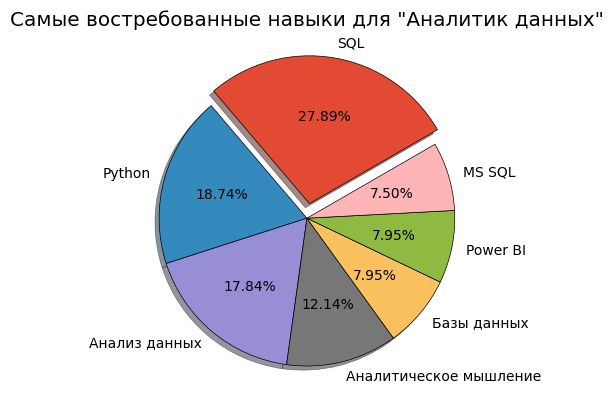

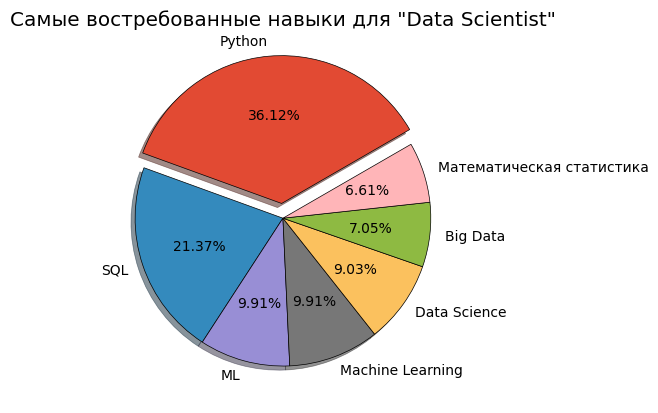

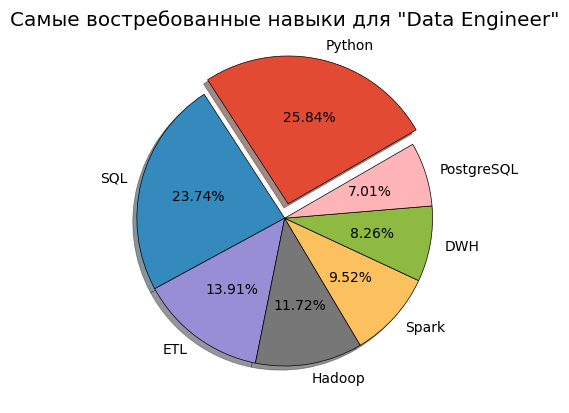

Самый востребованный навык для "Аналитик данных": SQL
Самый востребованный навык для "Data Scientist": Python
Самый востребованный навык для "Data Engineer": Python


In [6]:
# Для каждой искомой вакансии считаем указанные ключевые навыки
# И на основании подсчетов строим круговые диаграммы
lst_result = []

for vac in lst_vacs:
    name = ' '.join(vac)
    filter = (Full_vacs_df['user_request'] == name)
    filtered_df = Full_vacs_df[filter].key_skills.apply(key_skills_to_lst)
    filtered_df = filtered_df.dropna()
    
    lst_temp = []
    for i in range(len(filtered_df)):
        lst_temp.extend(filtered_df.iloc[i])
        
    count_skills = Counter(lst_temp)
    count_skills = pd.Series(count_skills).sort_values(ascending=False)
    
    labels = count_skills.index[0:7]
    share = count_skills.iloc[0:7]
    explode = (0.1, 0, 0, 0, 0,0,0)
    plt.style.use('ggplot')
    plt.title(f'Самые востребованные навыки для "{name}"')
    plt.pie(x = share, labels=labels, autopct='%.2f%%', explode=explode,
            shadow=True, startangle=30, wedgeprops={'edgecolor': 'black'})
    plt.show()
    
    lst_result.append(f'Самый востребованный навык для "{name}": {count_skills.idxmax()}')
print(*lst_result, sep='\n')

# Подготовка оставшихся данных для последующих исследований

In [7]:
# Расскрываем словари: вилки зарплат, регионы, наименования организаций. 
# И распределяем данные по колонкам
Full_vacs_df['salary'] = Full_vacs_df['salary'].apply(del_notrur)
Full_vacs_df['salary_from'] = Full_vacs_df['salary'].apply(lambda cell: cell['from'] if cell else None)
Full_vacs_df['salary_to'] = Full_vacs_df['salary'].apply(lambda cell: cell['to'] if cell else None)
Full_vacs_df['area'] = Full_vacs_df['area'].apply(lambda cell: cell['name'])
Full_vacs_df['employer'] = Full_vacs_df['employer'].apply(lambda cell: cell['name'])
Full_vacs_df['schedule'] = Full_vacs_df['schedule'].apply(lambda cell: cell['name'])
Full_vacs_df['key_skills'] = Full_vacs_df['key_skills'].apply(key_skills_to_lst)
Full_vacs_df['key_skills'] = Full_vacs_df['key_skills'].apply(lambda lst: None if lst == None else ', '.join(lst).lower())
Full_vacs_df.drop(columns=['salary'], inplace=True)
Full_vacs_df.sample(2)

,id,published_at,name,area,employer,user_request,description,key_skills,schedule,salary_from,salary_to
235,80051851,2023-05-03,Аналитик Данных / Data Analyst (Ценообразование),Москва,Спортмастер,Аналитик данных,В Департамент анализа данных и машинного обуче...,None,Удаленная работа,NaN,NaN
258,79951206,2023-05-01,Аналитик разработчик отдела отчетности и качес...,Кемерово,Уральская горно-металлургическая компания,Аналитик данных,АО «УК «Кузбассразрезуголь» - одна из ведущих ...,None,Полный день,NaN,NaN


In [27]:
Full_vacs_df['schedule'].value_counts()

Полный день         956
Удаленная работа    217
Гибкий график        37
Вахтовый метод        2
Сменный график        1
Name: schedule, dtype: int64

In [8]:
# Количество указанных 
print(Full_vacs_df['salary_from'].notna().sum())
print(Full_vacs_df['salary_to'].notna().sum())
print(Full_vacs_df['schedule'].notna().sum())

150
105
1213


## Количество вакансий по городам

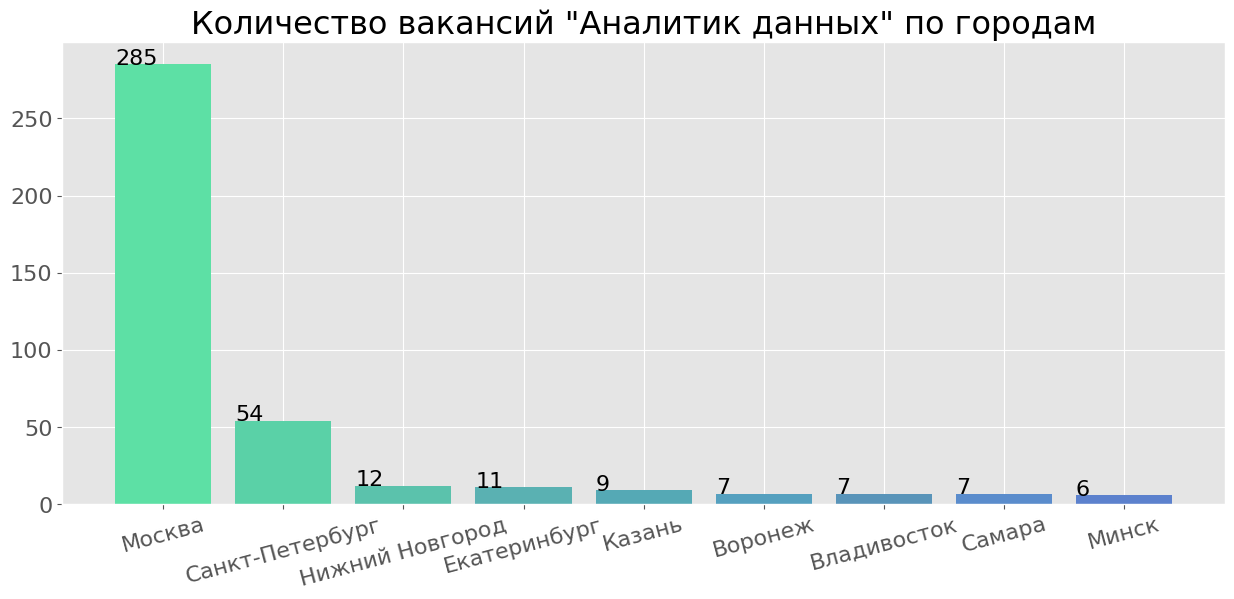

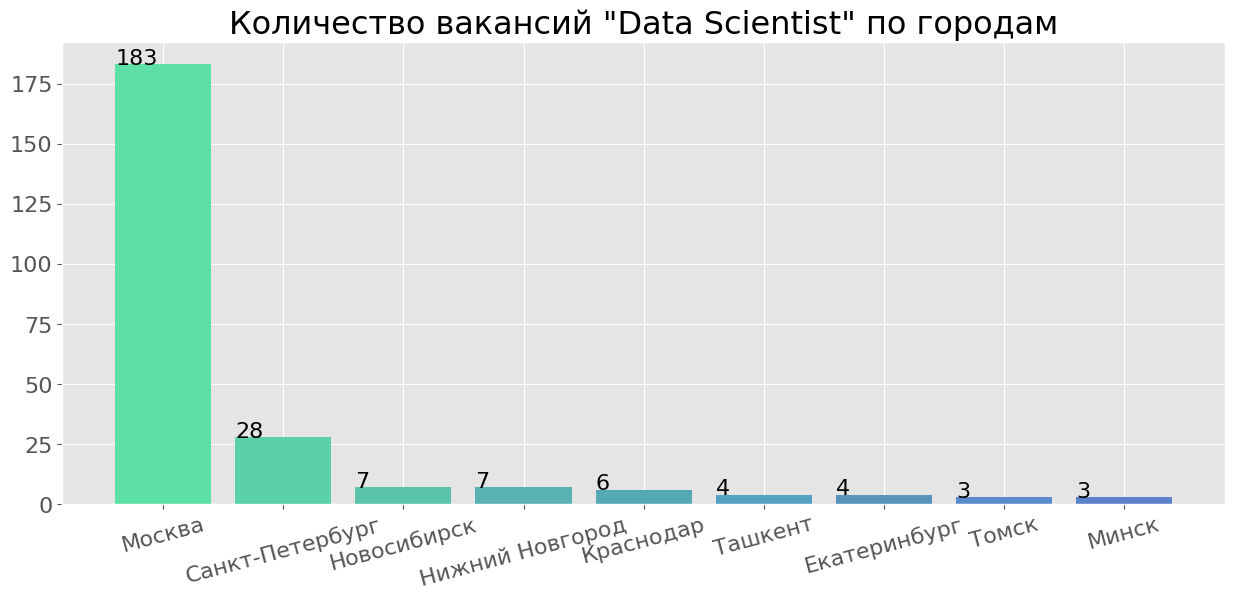

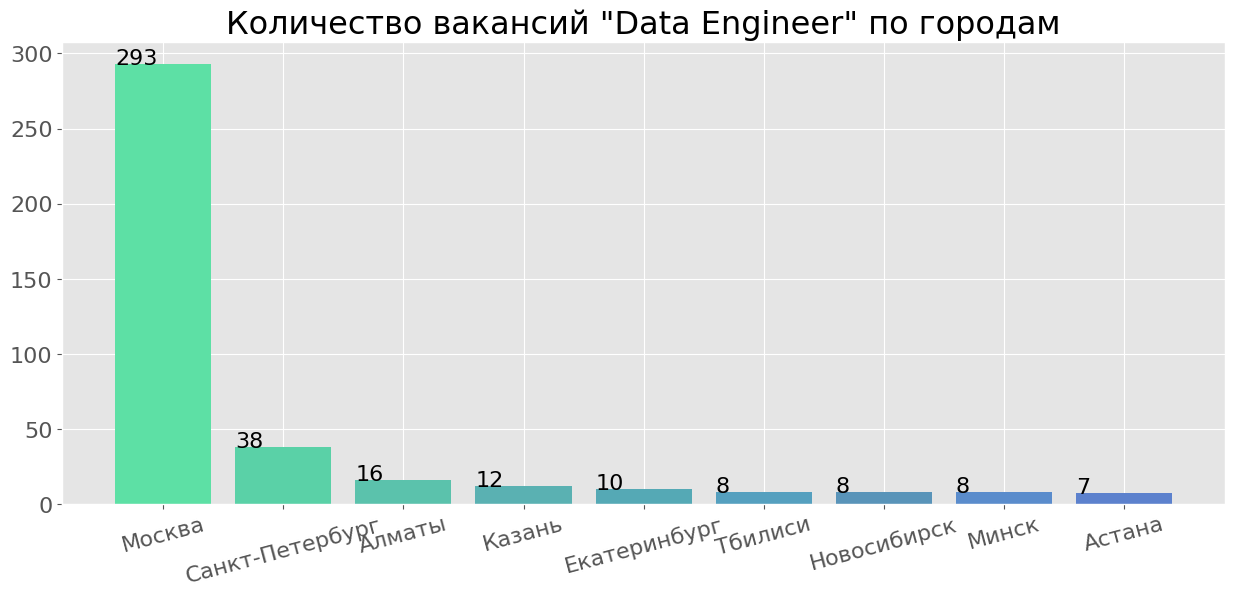

In [30]:
for vac in lst_vacs:
    name = ' '.join(vac)
    filter = (Full_vacs_df['user_request'] == name)
    df = Full_vacs_df[filter]

    fig, ax = plt.subplots(figsize=(15,6))
    ax.bar(df['area'].value_counts().head(9).index, df['area'].value_counts().head(9), color=colors_lst[::2])
    for i in ax.patches:
        ax.annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
    ax.tick_params('x', rotation=15)
    plt.title(f'Количество вакансий "{name}" по городам')
    plt.rc('font', size=16)
    plt.show()

## Количество вакансий по организациям

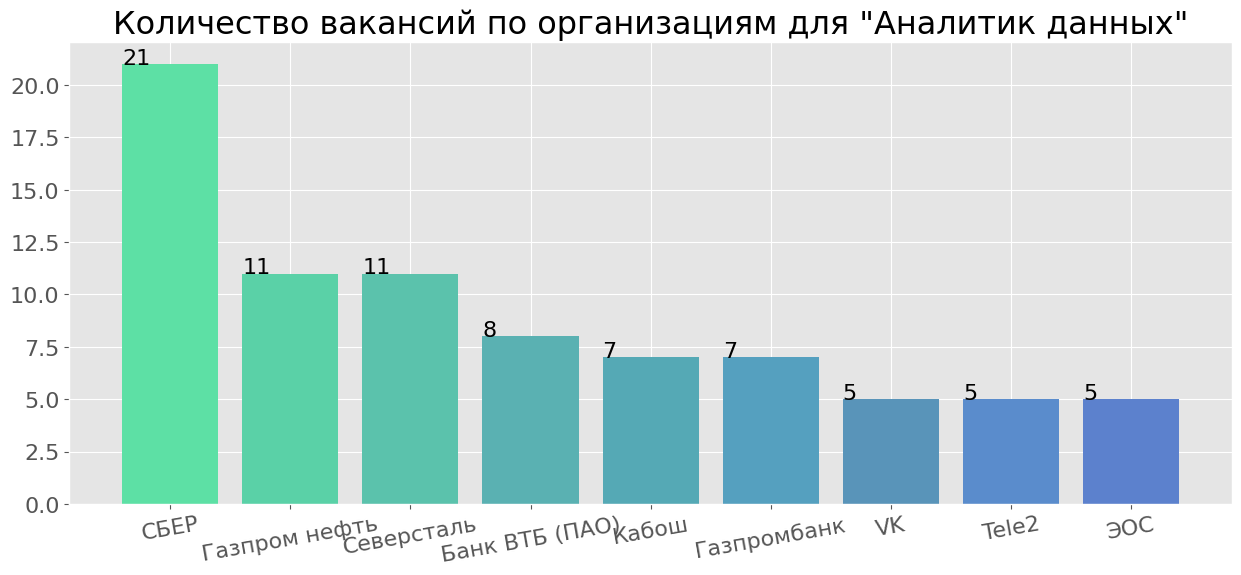

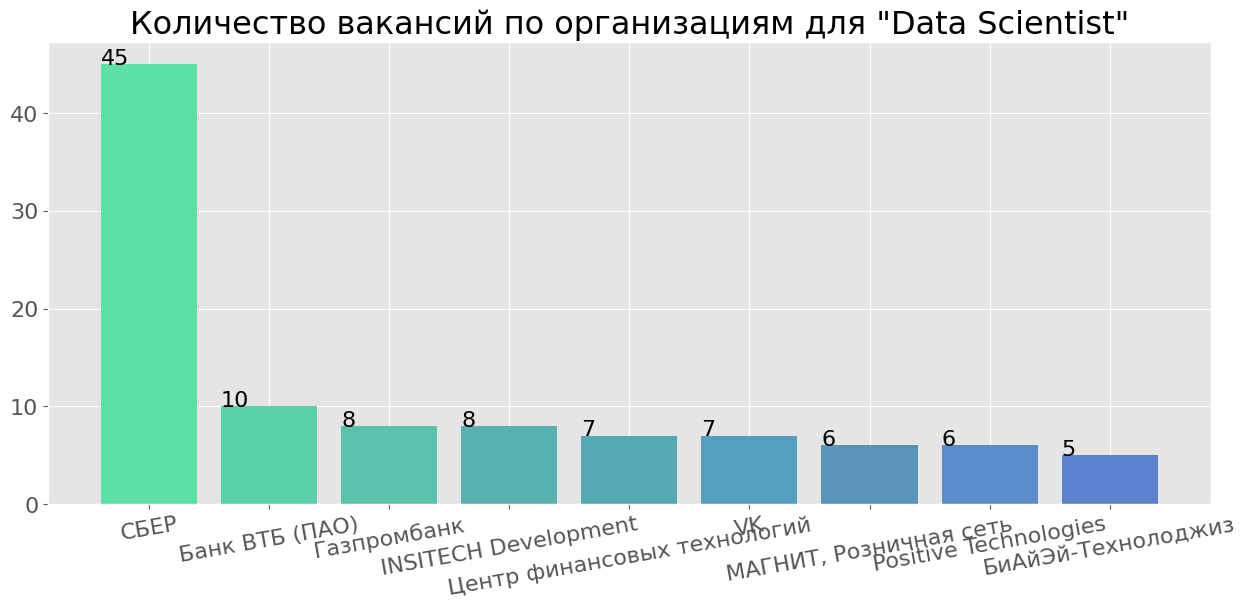

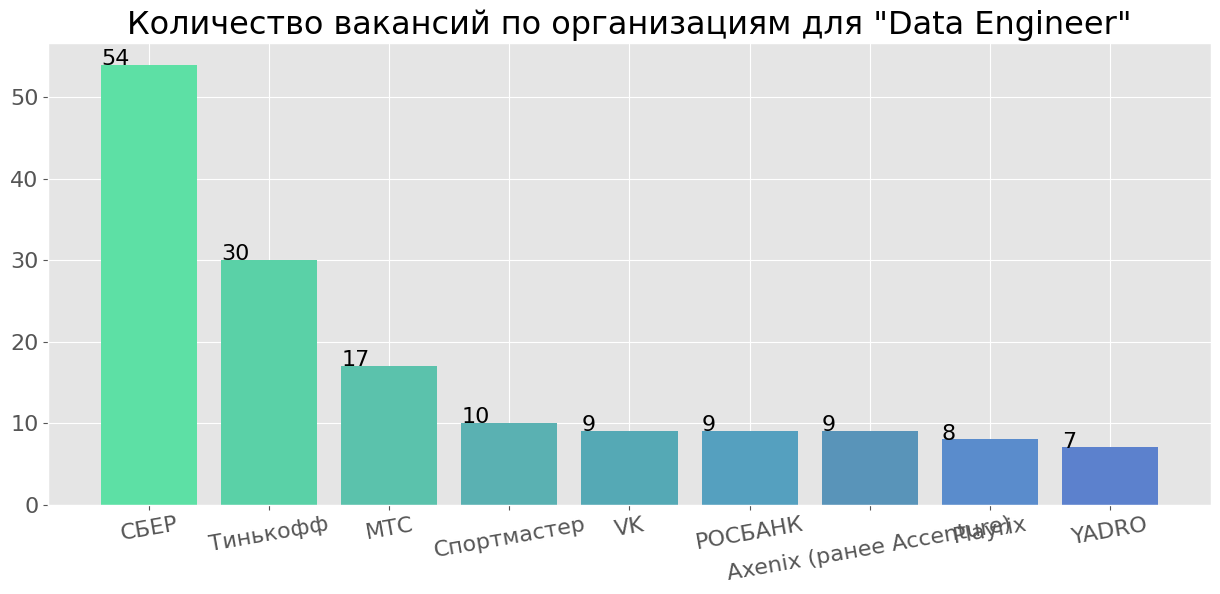

In [31]:
for vac in lst_vacs:
    name = ' '.join(vac)
    filter = (Full_vacs_df['user_request'] == name)
    df = Full_vacs_df[filter]


    fig, ax = plt.subplots(figsize=(15,6))
    ax.bar(df['employer'].value_counts().head(9).index, df['employer'].value_counts().head(9), color=colors_lst[::2])
    for i in ax.patches:
        ax.annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
    ax.tick_params('x', rotation=10)
    plt.title(f'Количество вакансий по организациям для "{name}"')
    plt.rc('font', size=16)
    plt.show()

## Средняя зар.плата по организациям

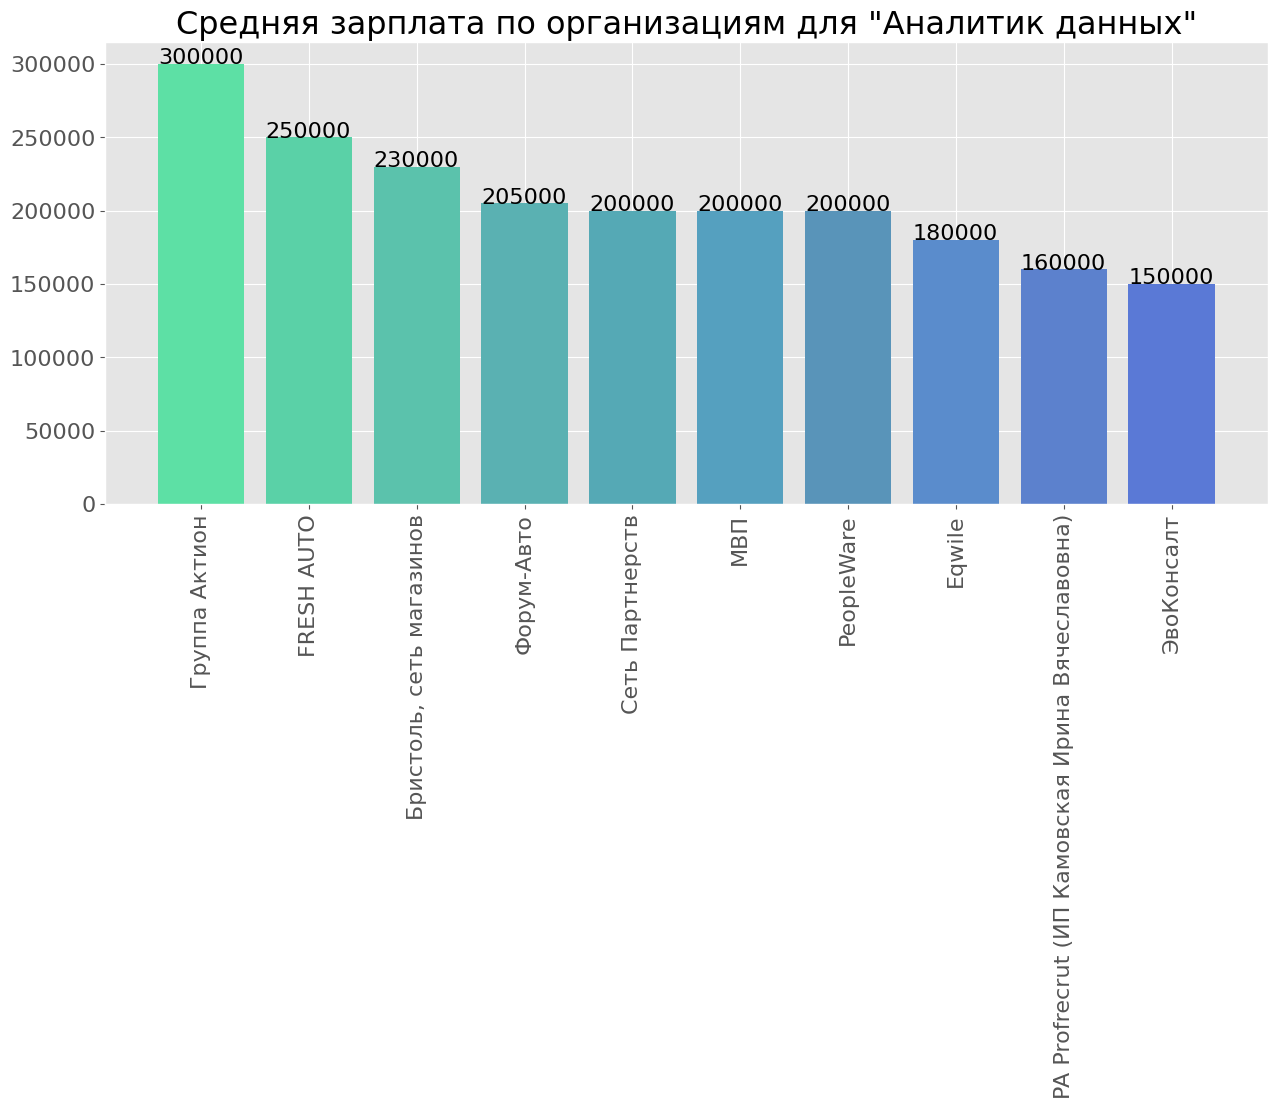

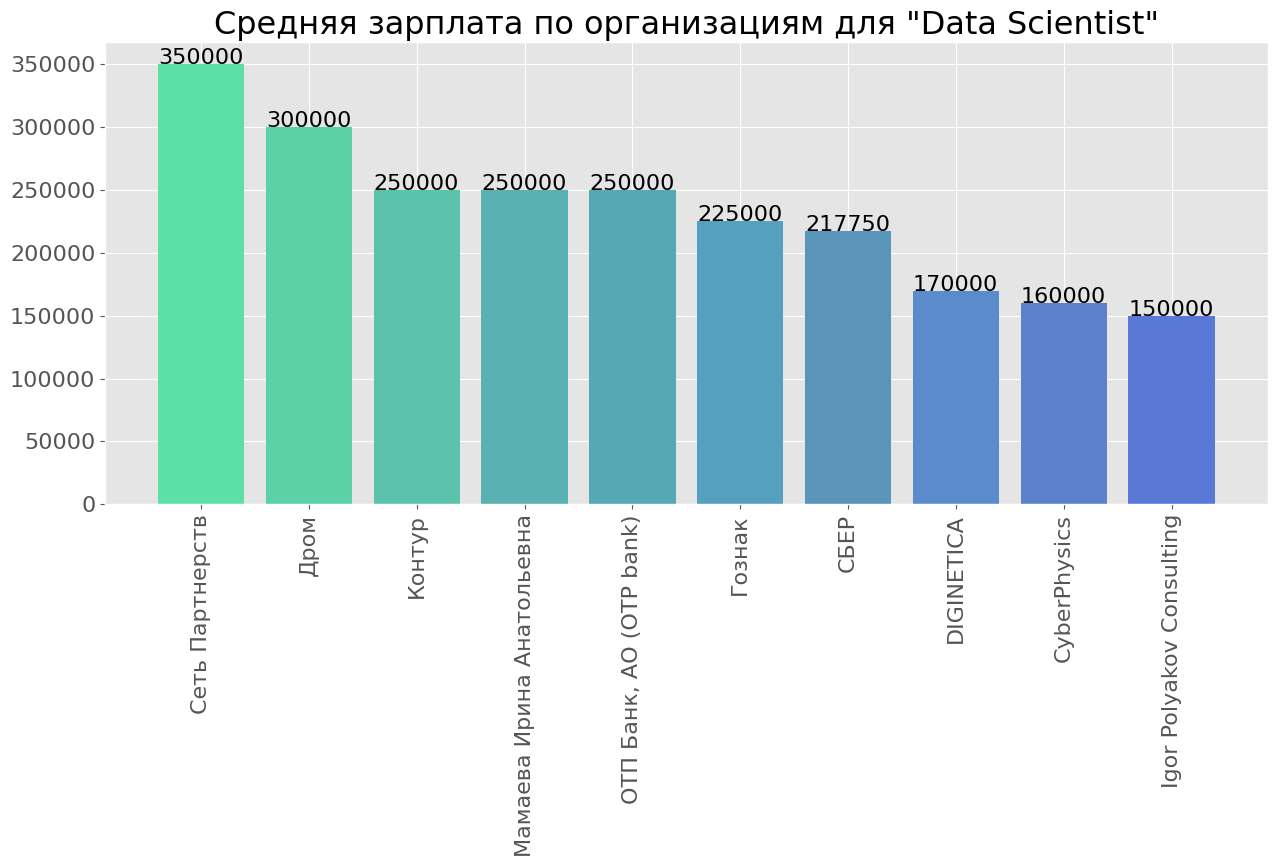

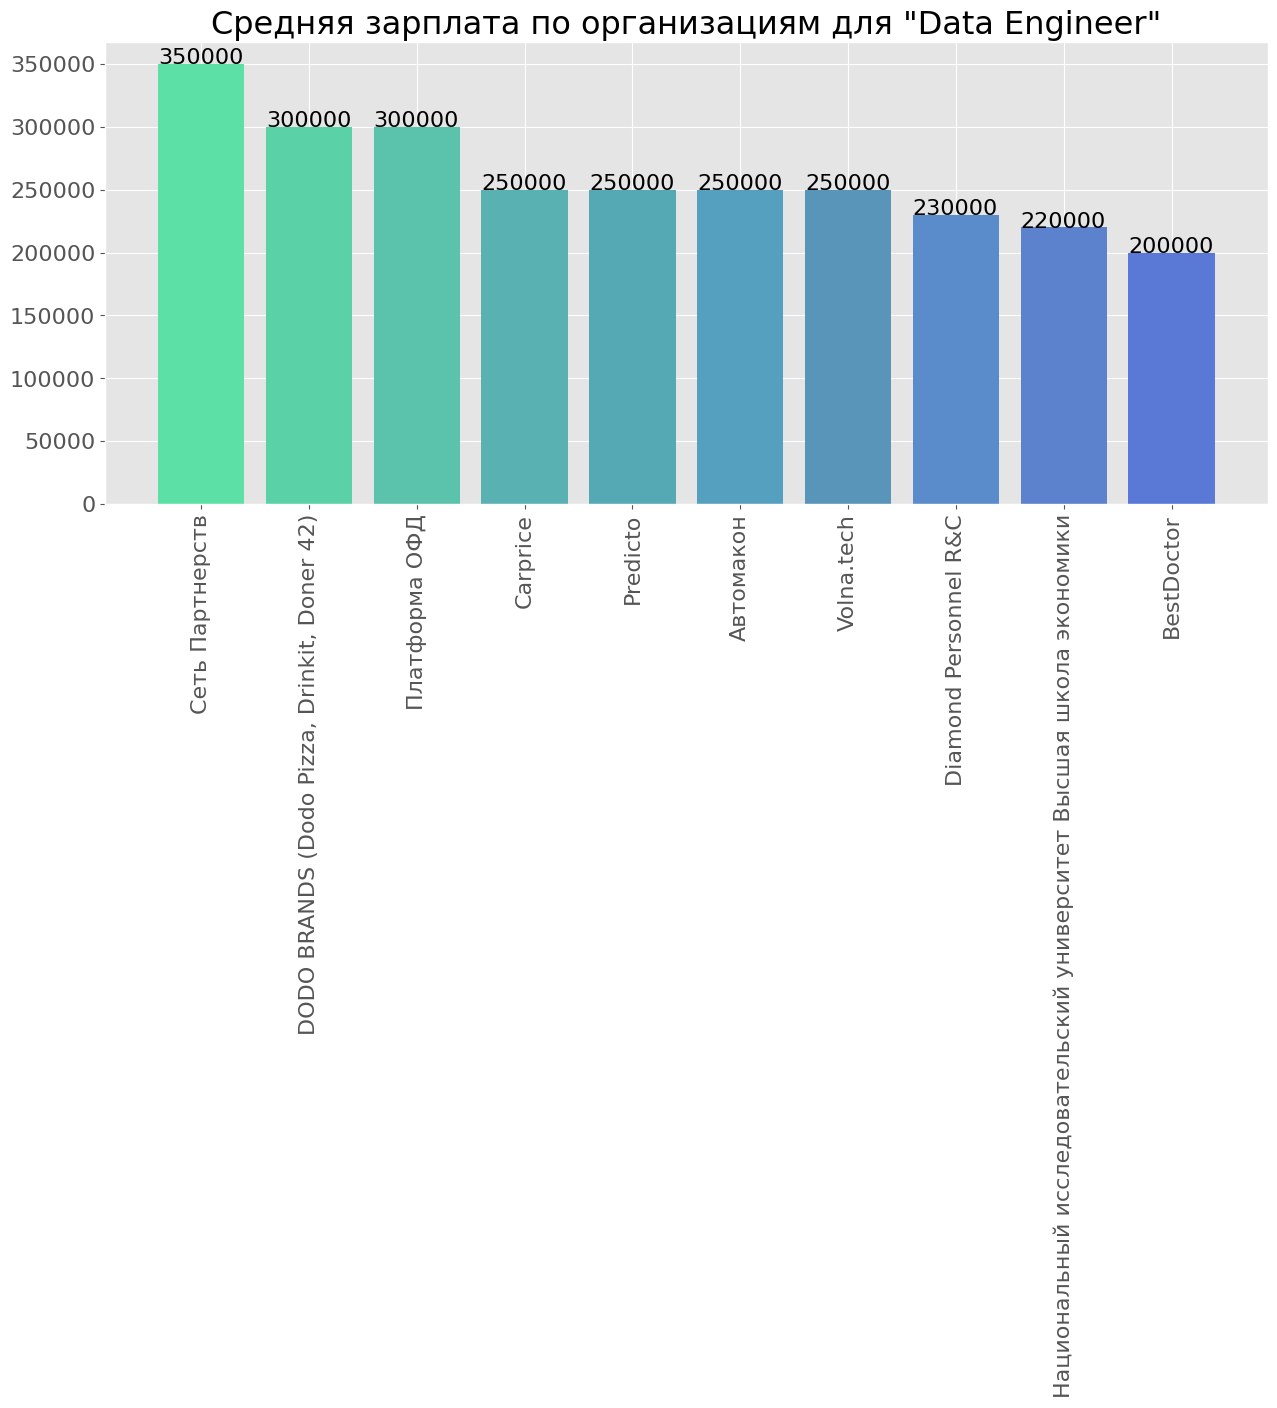

In [33]:
for vac in lst_vacs:
    name = ' '.join(vac)
    filter1 = (Full_vacs_df['user_request'] == name)
    filter2 = (Full_vacs_df['salary_from'].isna == False)
    df = Full_vacs_df[filter1].groupby('employer')['salary_from'].median().sort_values(ascending=False).head(10)

    fig, ax = plt.subplots(figsize=(15,6))
    ax.bar(df.index, df.values, color=colors_lst[::2])
    for i in ax.patches:
        ax.annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
    ax.tick_params('x', rotation=90)
    plt.title(f'Средняя зарплата по организациям для "{name}"')
    plt.rc('font', size=16)
    plt.show()

## Количество предложений удаленной работы по организациям

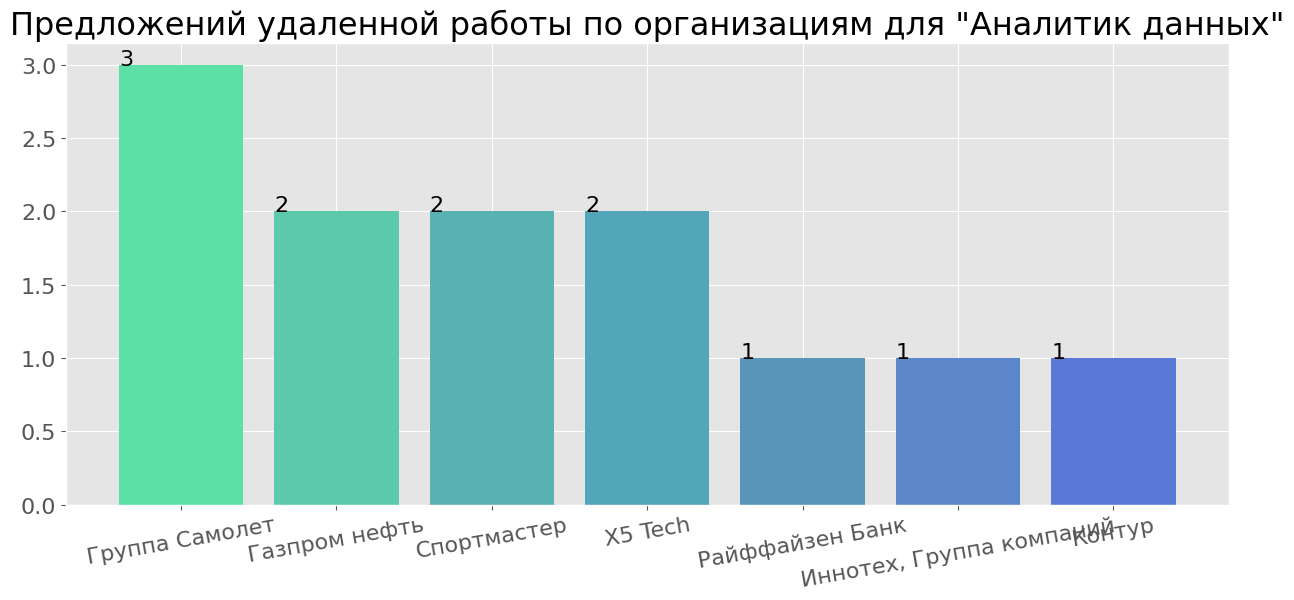

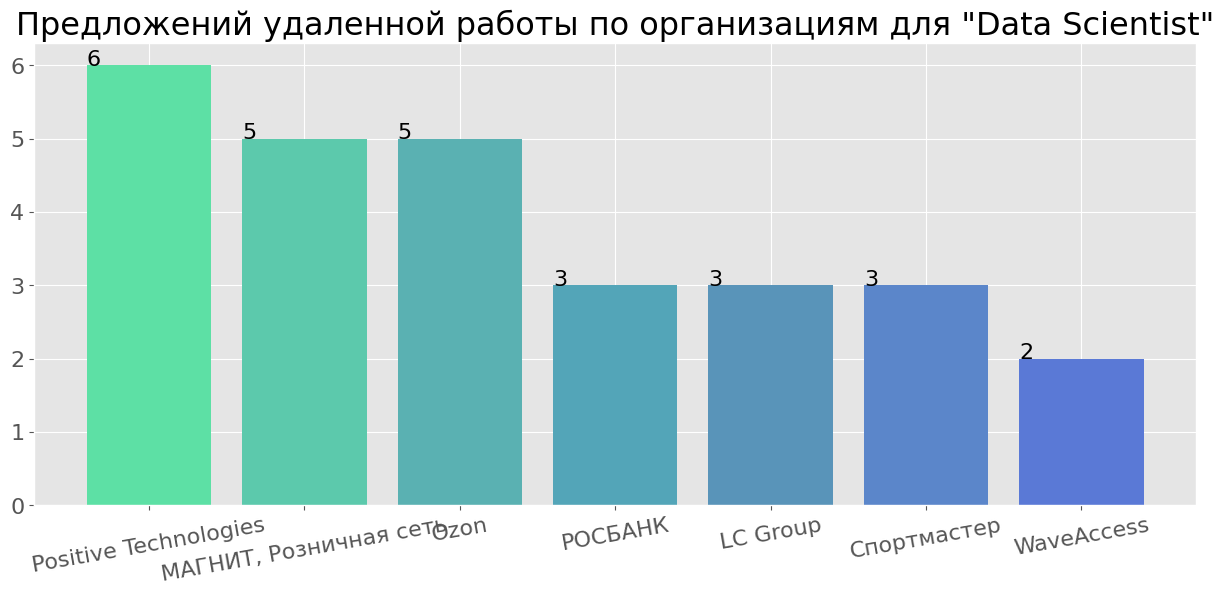

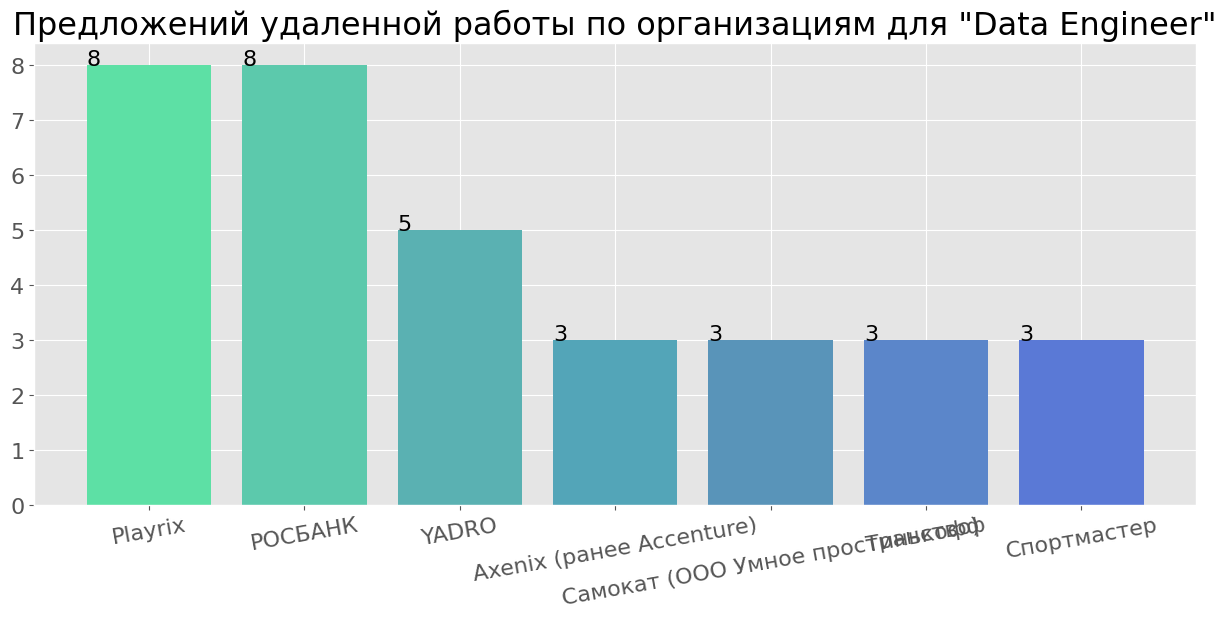

In [35]:
for vac in lst_vacs:
    name = ' '.join(vac)
    filter1 = (Full_vacs_df['user_request'] == name)
    filter2 = (Full_vacs_df['schedule'] == 'Удаленная работа')
    df = Full_vacs_df[filter1 & filter2].groupby('employer')['schedule'].value_counts().sort_values(ascending=False).head(7)

    fig, ax = plt.subplots(figsize=(15,6))
    ax.bar(df.index.get_level_values('employer'), df.values, color=colors_lst[::3])
    for i in ax.patches:
        ax.annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
    ax.tick_params('x', rotation=10)
    plt.title(f'Предложений удаленной работы по организациям для "{name}"')
    plt.rc('font', size=16)
    plt.show()

## Средняя зарплата удаленной работы по городам

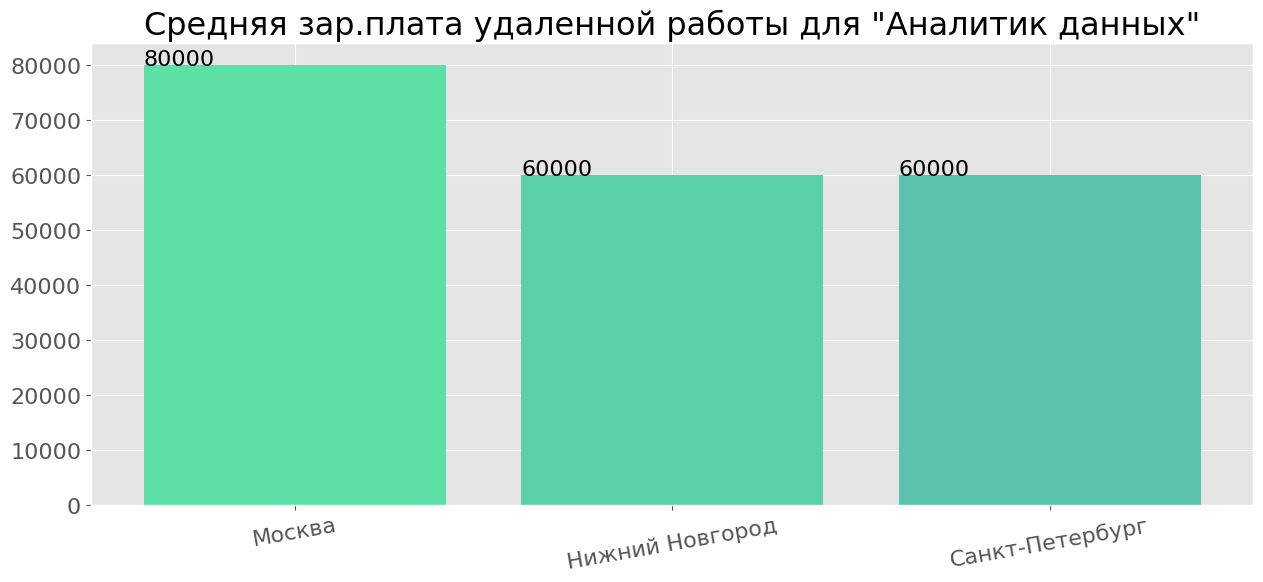

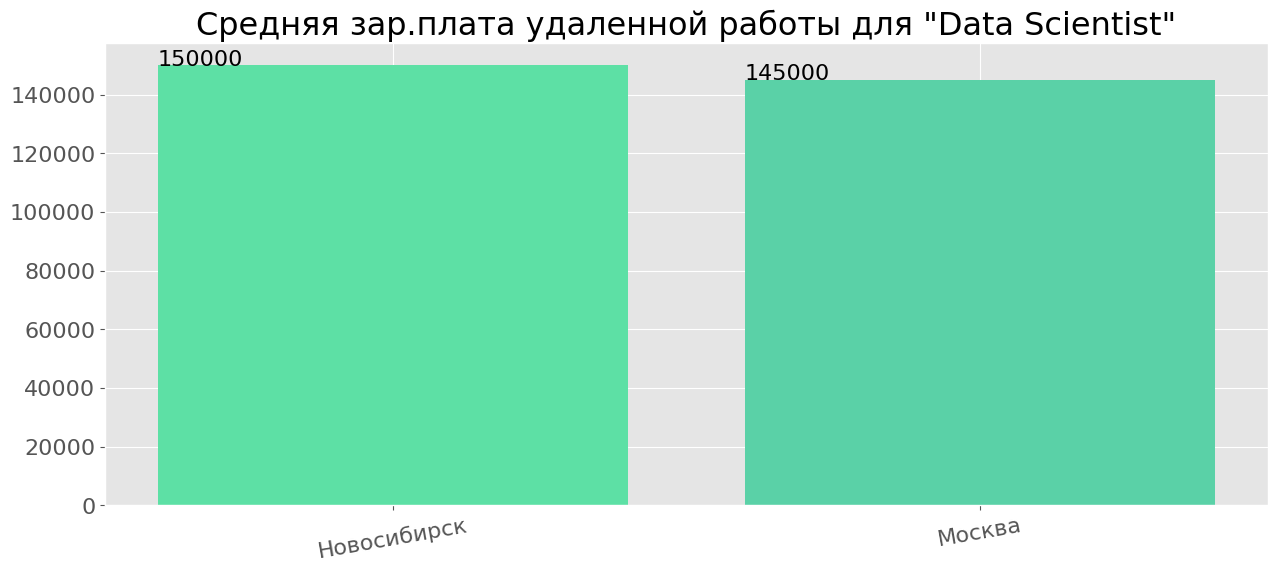

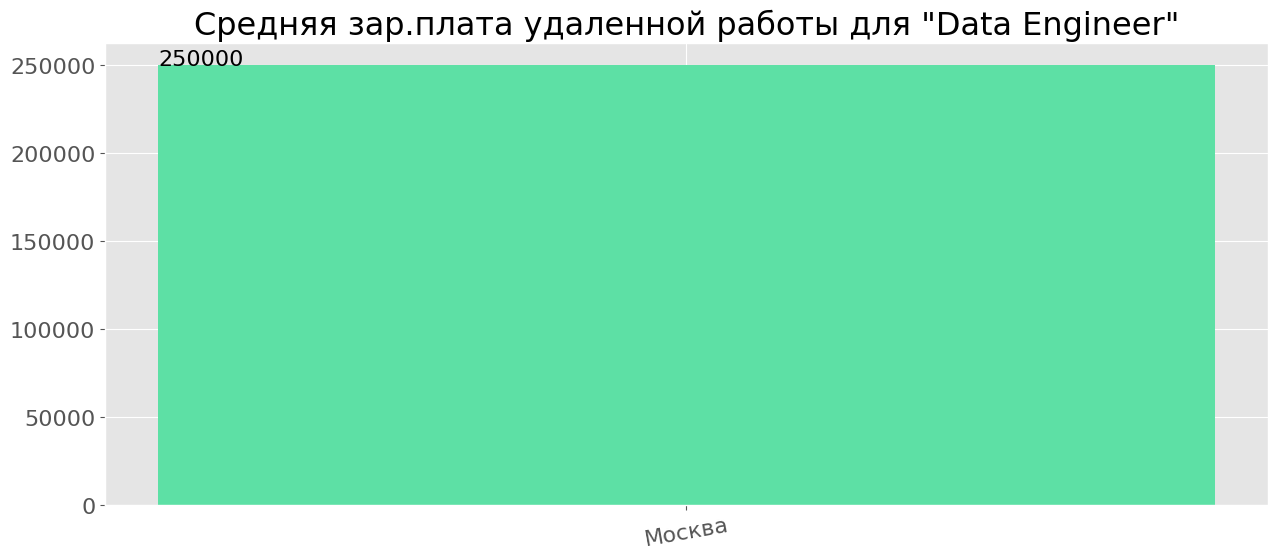

In [36]:
for vac in lst_vacs:
    name = ' '.join(vac)
    filter1 = (Full_vacs_df['user_request'] == name)
    filter2 = (Full_vacs_df['schedule'] == 'Удаленная работа')
    filter3 = (Full_vacs_df['salary_from'].isna() == False)
    df = Full_vacs_df[filter1 & filter2 & filter3].groupby('area')['salary_from'].median().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(15,6))
    ax.bar(df.index, df.values, color=colors_lst[::2])
    for i in ax.patches:
        ax.annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
    ax.tick_params('x', rotation=10)
    plt.title(f'Средняя зар.плата удаленной работы для "{name}"')
    plt.rc('font', size=16)
    plt.show()

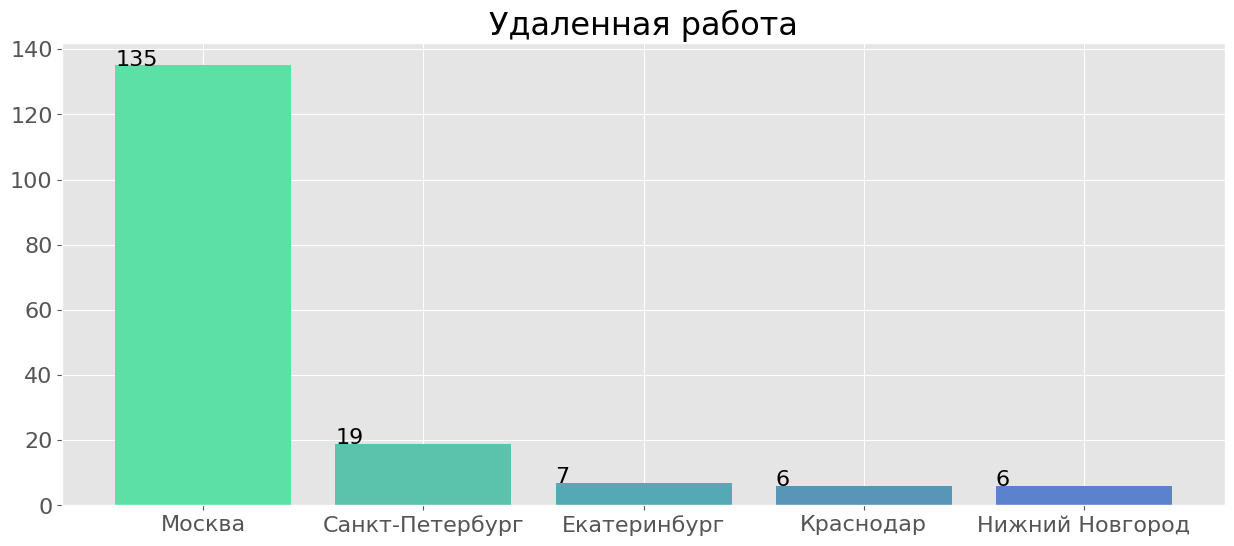

In [37]:
filter = (Full_vacs_df['schedule'] == 'Удаленная работа')
df = Full_vacs_df[filter]
df['area'].value_counts()

fig, ax = plt.subplots(figsize=(15,6))
ax.bar(df['area'].value_counts().head(5).index, df['area'].value_counts().head(5).values, color=colors_lst[::4])
for i in ax.patches:
    ax.annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
plt.title('Удаленная работа')
plt.show()

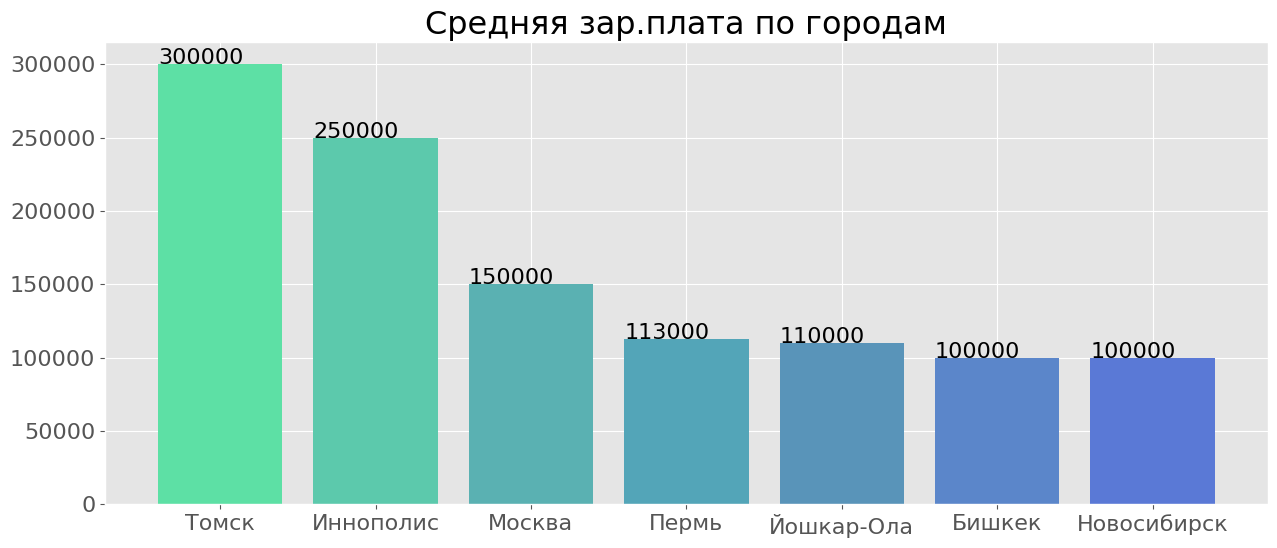

In [38]:
payment_avg = Full_vacs_df[Full_vacs_df['salary_from'].isna() == False].groupby('area')['salary_from'].median().sort_values(ascending=False).head(7)
fig, ax = plt.subplots(figsize=(15,6))
ax.bar(payment_avg.index, payment_avg.values, color=colors_lst[::3])
for i in ax.patches:
    ax.annotate('%1.0f'%(i.get_height()), (i.get_x(), i.get_height()))
plt.title('Средняя зар.плата по городам')
plt.show()

# Градация специалистов

In [43]:
Full_vacs_df.sample(5)

,id,published_at,name,area,employer,user_request,description,key_skills,schedule,salary_from,salary_to
1172,77215006,2023-04-19,Scala Data Engineer,Москва,МегаФон,Data Engineer,Мы разрабатываем облачную платформу конфиденци...,"scala, spark, java",Удаленная работа,NaN,NaN
569,79679708,2023-04-21,Data Scientist,Тбилиси,INSITECH Development,Data Scientist,Мы в компании «INSITECH Development» работаем ...,"python, грамотная речь, sql, clickhouse, hive,...",Полный день,NaN,NaN
339,78386603,2023-04-17,Аналитик данных по медиастратегии,Москва,VK,Аналитик данных,Мы занимаемся различного рода аналитическими з...,"sql, python, bi, математическая статистика, ан...",Полный день,NaN,NaN
437,79009313,2023-05-10,Специалист по анализу данных об угрозах (Cyber...,Москва,BI.ZONE,Аналитик данных,BI.ZONE создает IT-продукты для обеспечения ки...,None,Полный день,NaN,NaN
235,80051851,2023-05-03,Аналитик Данных / Data Analyst (Ценообразование),Москва,Спортмастер,Аналитик данных,В Департамент анализа данных и машинного обуче...,None,Удаленная работа,NaN,NaN


In [10]:
# фильтры для разделения искомых вакансий на градации требуемого опыта
junior = ((Full_vacs_df['description'].str.contains('junior|начинающий', na=False, flags=re.IGNORECASE, regex=True) == True) | (Full_vacs_df['name'].str.contains('junior|начинающий', na=False, flags=re.IGNORECASE, regex=True) == True))
middle = ((Full_vacs_df['description'].str.contains('middle|средний', na=False, flags=re.IGNORECASE, regex=True) == True) | (Full_vacs_df['name'].str.contains('middle|средний', na=False, flags=re.IGNORECASE, regex=True) == True))
senior = ((Full_vacs_df['description'].str.contains('senior|продвинутый', na=False, flags=re.IGNORECASE, regex=True) == True) | (Full_vacs_df['name'].str.contains('senior|продвинутый', na=False, flags=re.IGNORECASE, regex=True) == True))
head = ((Full_vacs_df['description'].str.contains('head|руководитель', na=False, flags=re.IGNORECASE, regex=True) == True) | (Full_vacs_df['name'].str.contains('head|руководитель', na=False, flags=re.IGNORECASE, regex=True) == True))
salary_mentioned = (Full_vacs_df['salary_from'].isna() == False)
salary_to_mentioned = (Full_vacs_df['salary_to'].isna() == False)
skills_mentioned = (Full_vacs_df['key_skills'].isna() == False)
grades = [junior,middle,senior,head]
grades_titles = ['junior','middle','senior','head']


print('Кол-во вакансий junior: ', Full_vacs_df[junior].shape[0])
print('Кол-во вакансий middle: ', Full_vacs_df[middle].shape[0])
print('Кол-во вакансий senior: ', Full_vacs_df[senior].shape[0])
print('Кол-во вакансий head: ', Full_vacs_df[head].shape[0])
print()
print('Кол-во вакансий junior с указанной зарплатой: ', Full_vacs_df[junior & salary_mentioned].shape[0])
print('Кол-во вакансий middle с указанной зарплатой: ', Full_vacs_df[middle & salary_mentioned].shape[0])
print('Кол-во вакансий senior с указанной зарплатой: ', Full_vacs_df[senior & salary_mentioned].shape[0])
print('Кол-во вакансий head с указанной зарплатой: ', Full_vacs_df[head & salary_mentioned].shape[0])
print()
print('Кол-во вакансий junior с указанными навыками: ', Full_vacs_df[junior & skills_mentioned].shape[0])
print('Кол-во вакансий middle с указанными навыками: ', Full_vacs_df[middle & skills_mentioned].shape[0])
print('Кол-во вакансий senior с указанными навыками: ', Full_vacs_df[senior & skills_mentioned].shape[0])
print('Кол-во вакансий head с указанными навыками: ', Full_vacs_df[head & skills_mentioned].shape[0])
print()
print('Кол-во вакансий junior с указанными навыками и зарплатой: ', Full_vacs_df[junior & salary_mentioned & skills_mentioned].shape[0])
print('Кол-во вакансий middle с указанными навыками и зарплатой: ', Full_vacs_df[middle & salary_mentioned & skills_mentioned].shape[0])
print('Кол-во вакансий senior с указанными навыками и зарплатой: ', Full_vacs_df[senior & salary_mentioned & skills_mentioned].shape[0])
print('Кол-во вакансий head с указанными навыками и зарплатой: ', Full_vacs_df[head & salary_mentioned & skills_mentioned].shape[0])
print()

for vac in lst_vacs:
    name = ' '.join(vac)
    filter1 = (Full_vacs_df['user_request'] == name)
    for grade_index in range(len(grades)):
        amount = Full_vacs_df[filter1 & grades[grade_index] & salary_mentioned & skills_mentioned].shape[0]
        print(f'Кол-во вакансий {grades_titles[grade_index]} с указанными навыками и зарплатой для {name}: {amount}')
    print()


#Full_vacs_df[junior & salary_mentioned]
#Full_vacs_df[middle & salary_mentioned]
#Full_vacs_df[senior & salary_mentioned]
#Full_vacs_df[head & salary_mentioned]
#Full_vacs_df[junior]
#Full_vacs_df[middle]
#Full_vacs_df[senior]
#Full_vacs_df[head]

Кол-во вакансий junior:  43
Кол-во вакансий middle:  128
Кол-во вакансий senior:  227
Кол-во вакансий head:  32

Кол-во вакансий junior с указанной зарплатой:  10
Кол-во вакансий middle с указанной зарплатой:  17
Кол-во вакансий senior с указанной зарплатой:  24
Кол-во вакансий head с указанной зарплатой:  4

Кол-во вакансий junior с указанными навыками:  29
Кол-во вакансий middle с указанными навыками:  92
Кол-во вакансий senior с указанными навыками:  152
Кол-во вакансий head с указанными навыками:  26

Кол-во вакансий junior с указанными навыками и зарплатой:  6
Кол-во вакансий middle с указанными навыками и зарплатой:  14
Кол-во вакансий senior с указанными навыками и зарплатой:  19
Кол-во вакансий head с указанными навыками и зарплатой:  4

Кол-во вакансий junior с указанными навыками и зарплатой для Аналитик данных: 2
Кол-во вакансий middle с указанными навыками и зарплатой для Аналитик данных: 5
Кол-во вакансий senior с указанными навыками и зарплатой для Аналитик данных: 6
Кол-

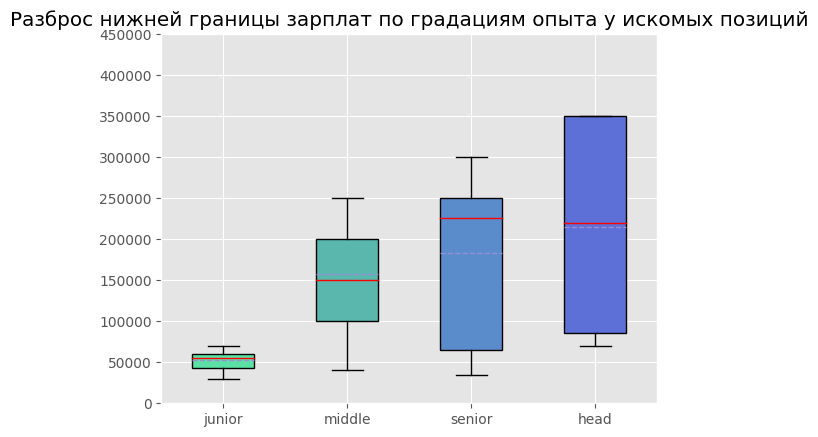

In [91]:
box1_salary_from = Full_vacs_df[junior & salary_mentioned]['salary_from']
box2_salary_from = Full_vacs_df[middle & salary_mentioned]['salary_from']
box3_salary_from = Full_vacs_df[senior & salary_mentioned]['salary_from']
box4_salary_from = Full_vacs_df[head & salary_mentioned]['salary_from']
y_salary_from = [box1_salary_from,box2_salary_from,box3_salary_from,box4_salary_from]

colors = ['#5de0a5','#59b7ad','#5a8ccc','#5d70d8']

fig, ax = plt.subplots()
boxes = ax.boxplot(y_salary_from, labels=['junior','middle','senior','head'],
                widths=0.5, patch_artist=True, whis=1,
                boxprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                showmeans=True, showfliers=True,
                meanline=True, medianprops=dict(color='red'))

for patch, color in zip(boxes['boxes'],colors):
    patch.set_facecolor(color)

ax.set(ylim=(0, Full_vacs_df['salary_to'].max()))
plt.title('Разброс нижней границы зарплат по градациям опыта у искомых позиций')
plt.show()

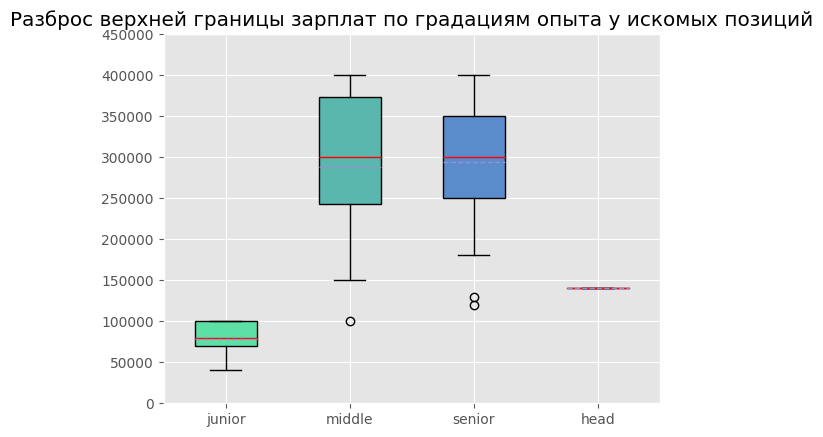

In [92]:
box1_salary_to = Full_vacs_df[junior & salary_to_mentioned]['salary_to']
box2_salary_to = Full_vacs_df[middle & salary_to_mentioned]['salary_to']
box3_salary_to = Full_vacs_df[senior & salary_to_mentioned]['salary_to']
box4_salary_to = Full_vacs_df[head & salary_to_mentioned]['salary_to']
y_salary_to = [box1_salary_to,box2_salary_to,box3_salary_to,box4_salary_to]

colors = ['#5de0a5','#59b7ad','#5a8ccc','#5d70d8']

fig, ax = plt.subplots()
boxes = ax.boxplot(y_salary_to, labels=['junior','middle','senior','head'],
                widths=0.5, patch_artist=True, whis=1,
                boxprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                showmeans=True, showfliers=True,
                meanline=True, medianprops=dict(color='red'))

for patch, color in zip(boxes['boxes'],colors):
    patch.set_facecolor(color)

ax.set(ylim=(0, Full_vacs_df['salary_to'].max()))
plt.title('Разброс верхней границы зарплат по градациям опыта у искомых позиций')
plt.show()

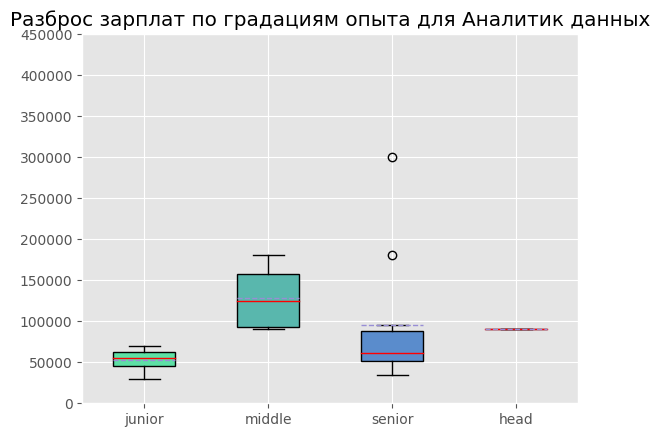

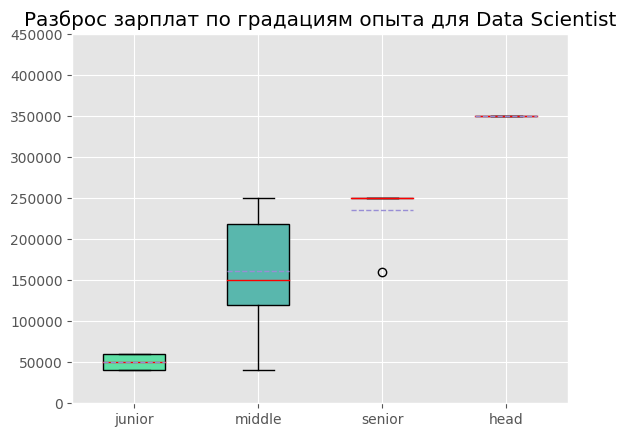

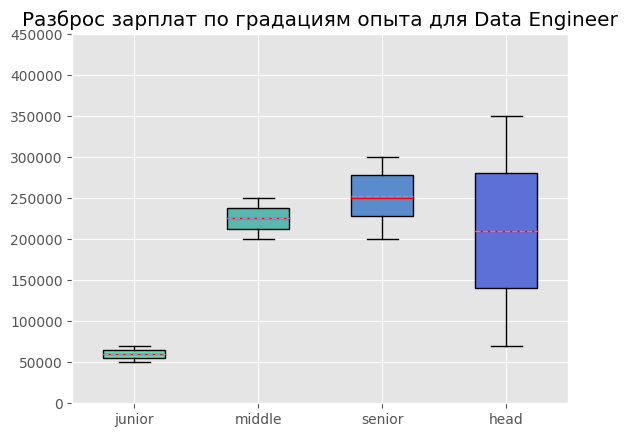

In [21]:
for vac in lst_vacs:
    lst_grades_temp = []
    name = ' '.join(vac)
    filter_request = (Full_vacs_df['user_request'] == name)
    for grade_index in range(len(grades)):
        df_grade = Full_vacs_df[filter_request & grades[grade_index] & salary_mentioned]['salary_from']
        lst_grades_temp.append(df_grade)
        
    fig, ax = plt.subplots()
    boxes = ax.boxplot(lst_grades_temp, labels=['junior','middle','senior','head'],
                    widths=0.5, patch_artist=True, whis=1,
                    boxprops=dict(color='black'),
                    capprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    showmeans=True, showfliers=True,
                    meanline=True, medianprops=dict(color='red'))

    for patch, color in zip(boxes['boxes'],colors):
        patch.set_facecolor(color)

    ax.set(ylim=(0, Full_vacs_df['salary_to'].max()))
    plt.title(f'Разброс зарплат по градациям опыта для {name}')
    plt.show()

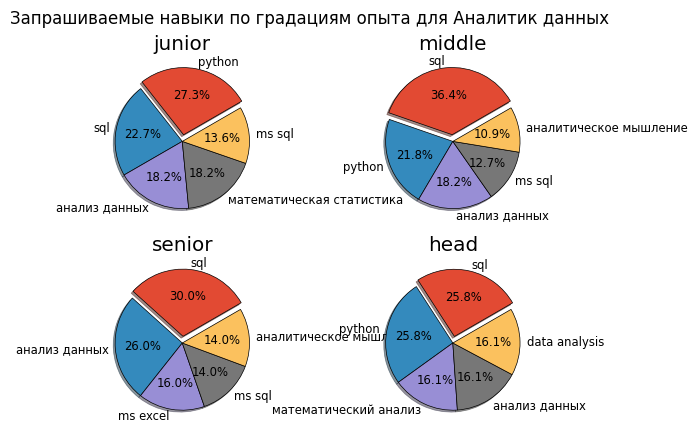

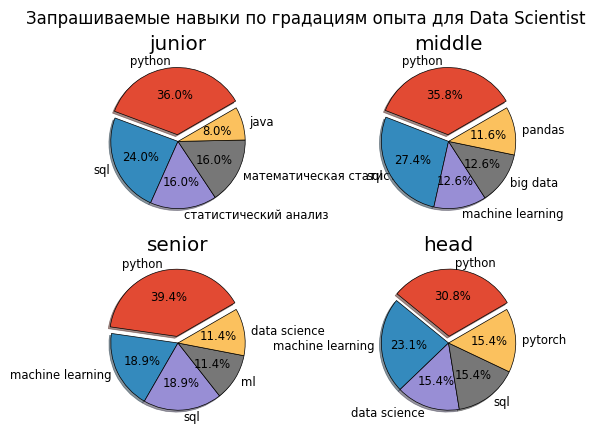

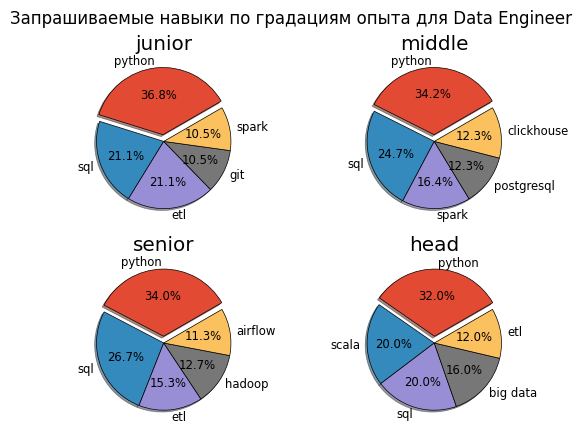

In [11]:
for vac in lst_vacs:
    lst_vac_skills = []
    name = ' '.join(vac)
    filter_request = (Full_vacs_df['user_request'] == name)
    for grade_index in range(len(grades)):
        grade_skills = []
        df_grade_skills = Full_vacs_df[filter_request & grades[grade_index] & skills_mentioned]['key_skills'].apply(lambda str: str.split(', '))
        for lst in df_grade_skills:
            grade_skills.extend(lst)
        count_skills = pd.Series(Counter(grade_skills)).sort_values(ascending=False)
        lst_vac_skills.append(count_skills[:5])

    fig, axs = plt.subplots(2,2)
    plt.style.use('ggplot')
    axs[0,0].pie(x = lst_vac_skills[0].iloc[0:5], labels=lst_vac_skills[0].index[0:5],
                autopct='%.1f%%', explode=(0.1, 0, 0, 0, 0), textprops={'size':'smaller'},
                shadow=True, startangle=30, wedgeprops={'edgecolor': 'black'})
    axs[0,0].set_title('junior')
    axs[0,1].pie(x = lst_vac_skills[1].iloc[0:5], labels=lst_vac_skills[1].index[0:5],
                autopct='%.1f%%', explode=(0.1, 0, 0, 0, 0), textprops={'size':'smaller'},
                shadow=True, startangle=30, wedgeprops={'edgecolor': 'black'})
    axs[0,1].set_title('middle')
    axs[1,0].pie(x = lst_vac_skills[2].iloc[0:5], labels=lst_vac_skills[2].index[0:5],
                autopct='%.1f%%', explode=(0.1, 0, 0, 0, 0), textprops={'size':'smaller'},
                shadow=True, startangle=30, wedgeprops={'edgecolor': 'black'})
    axs[1,0].set_title('senior')
    axs[1,1].pie(x = lst_vac_skills[3].iloc[0:5], labels=lst_vac_skills[3].index[0:5],
                autopct='%.1f%%', explode=(0.1, 0, 0, 0, 0), textprops={'size':'smaller'},
                shadow=True, startangle=30, wedgeprops={'edgecolor': 'black'})
    axs[1,1].set_title('head')
    fig.suptitle(f'Запрашиваемые навыки по градациям опыта для {name}')

    plt.show()

# Попробуем предположить зарплату по описанию вакансий методами ML.

#### Подготовка текста

In [94]:
Full_vacs_df.sample(2)

,id,published_at,name,area,employer,user_request,description,key_skills,schedule,salary_from,salary_to
1016,79478340,2023-04-18,Data Engineer,Москва,СБЕР,Data Engineer,В поиске Data Engineer`а в команду Data Scienc...,None,Полный день,NaN,NaN
557,79984154,2023-05-02,Data Scientist,Москва,М.Видео-Эльдорадо,Data Scientist,«М.Тех» - аккредитованная ИТ-компания и быстро...,"python, sql",Полный день,NaN,NaN


In [95]:
# применяем функцию очистки текста от латиницы и различных символов
df = Full_vacs_df.copy()
df['description_clean'] = remove_trash(df['description'])
df[['description', 'description_clean']].sample(2)

,description,description_clean
291,"MERLION – крупнейший российский дистрибьютор, ...",крупнейший российский дистрибьютор мы прода м...
128,"Наша команда отвечает за счастье покупателей, ...",Наша команда отвечает за счастье покупателей а...


In [100]:
%%time
"""
исполнение занимает примерно 30 сек для 1200 вакансий
"""
# Морфологический анализ для русского языка
# Применение функции лемматизации (приведение слов к начальным формам)
# для очищенного от различных символов текста

morph = pymorphy3.MorphAnalyzer()
df['description_clean_normal'] = df.apply(lemmatize, axis=1)

CPU times: total: 32.3 s
Wall time: 32.7 s


In [102]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [103]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALEXPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [106]:
stop_russian = stopwords.words('russian')

# Подготовка разных наборов данных для обучения, тестирования и применения модели

In [107]:
# Фильтры
filter_salary_ML = (df['salary_from'].isna() == False)
filter_no_salary_ML = (df['salary_from'].isna() == True)
# Фильтрованные таблицы
df_salary_filter = df[filter_salary_ML]
df_no_salary_filter = df[filter_no_salary_ML]

In [110]:
print('Исходная таблица всех вакансий: ', df.shape)
print('Таблица вакансий с указанными зарплатами: ', df_salary_filter.shape)
print('Таблица вакансий без указания зарплат: ', df_no_salary_filter.shape)

Исходная таблица всех вакансий:  (1213, 13)
Таблица вакансий с указанными зарплатами:  (150, 13)
Таблица вакансий без указания зарплат:  (1063, 13)


In [112]:
# настраиваем векторизацию текста (превращение текста в числовую матрицу сравнения слов 
# по частоте их появления и расчета их предположительной значимости по определенным формулам)
vectorizer = TfidfVectorizer(stop_words=stop_russian, 
                                   ngram_range=(1,1), 
                                   lowercase=True,
                                   max_features=10_000)

In [113]:
# применяем векторизацию к таблице с указанными зарплатами
vectorized_text_with_salary = vectorizer.fit_transform(df_salary_filter['description_clean_normal'])

In [114]:
print(len(vectorizer.get_feature_names_out()))
print(vectorized_text_with_salary.shape)
#vectorizer.vocabulary_
#vectorized


3242
(150, 3242)


In [115]:
# Разделяем векторизованную таблицу описаний на тренинговую и тестовую части
X_train, X_test, y_train, y_test = train_test_split(
    vectorized_text_with_salary, 
    df_salary_filter['salary_from'], 
    test_size=0.20, 
    random_state=42)

In [120]:
# Обучаем модели и применяем их сначала к тестовому набору данных, затем к тренинговому
ridge = Ridge(random_state=9)
ridge.fit(X_train, y_train)
y_ridge_pred_test = ridge.predict(X_test)
y_ridge_pred_train = ridge.predict(X_train)

print(ridge.score(X_test, y_ridge_pred_test))
print(ridge.intercept_)
print(ridge.coef_[0:10])
print()

GBR = GradientBoostingRegressor(random_state=9)
GBR.fit(X_train,y_train)
y_GBR_pred_test = GBR.predict(X_test)
y_GBR_pred_train = GBR.predict(X_train)
print(GBR.score(X_test, y_GBR_pred_test))

1.0
125793.02870972591
[   80.42416653     0.             0.          6392.93556835
 -1501.78683451 -3091.77778927 -4818.90603616  2599.3498449
 11755.84856295  5903.21016355]

1.0


# Оценка двух моделей

In [121]:
print('Ridge regression')
print('Ошибка RMSE, тестовые значение =', np.sqrt(mean_squared_error(y_test, y_ridge_pred_test)))
print('R2_score, тестовые значение =', r2_score(y_test, y_ridge_pred_test))
print('Ошибка MAE, тестовые значение =', mean_absolute_error(y_test, y_ridge_pred_test))
print('Ошибка MAPE, тестовые значение =', mean_absolute_percentage_error(y_test, y_ridge_pred_test))
print()
print('Ошибка RMSE, тренинг значения =', np.sqrt(mean_squared_error(y_train, y_ridge_pred_train)))
print('R2_score, тренинг значения =', r2_score(y_train, y_ridge_pred_train))
print('Ошибка MAE, тренинг значение =', mean_absolute_error(y_train, y_ridge_pred_train))
print('Ошибка MAPE, тренинг значение =', mean_absolute_percentage_error(y_train, y_ridge_pred_train))

Ridge regression
Ошибка RMSE, тестовые значение = 63078.906239377124
R2_score, тестовые значение = 0.4516531665337775
Ошибка MAE, тестовые значение = 48230.895408360055
Ошибка MAPE, тестовые значение = 0.62848151567759

Ошибка RMSE, тренинг значения = 34255.0806576126
R2_score, тренинг значения = 0.816338382751144
Ошибка MAE, тренинг значение = 26877.146952441686
Ошибка MAPE, тренинг значение = 0.32482380696145624


In [122]:
print('GradientBoostingRegressor')
print('Ошибка RMSE, тестовые значение =', np.sqrt(mean_squared_error(y_test, y_GBR_pred_test)))
print('R2_score, тестовые значение =', r2_score(y_test, y_GBR_pred_test))
print('Ошибка MAE, тестовые значение =', mean_absolute_error(y_test, y_GBR_pred_test))
print('Ошибка MAPE, тестовые значение =', mean_absolute_percentage_error(y_test, y_GBR_pred_test))
print()
print('Ошибка RMSE, тренинг значения =', np.sqrt(mean_squared_error(y_train, y_GBR_pred_train)))
print('R2_score, тренинг значения =', r2_score(y_train, y_GBR_pred_train))
print('Ошибка MAE, тренинг значение =', mean_absolute_error(y_train, y_GBR_pred_train))
print('Ошибка MAPE, тренинг значение =', mean_absolute_percentage_error(y_train, y_GBR_pred_train))

GradientBoostingRegressor
Ошибка RMSE, тестовые значение = 61402.775611680976
R2_score, тестовые значение = 0.4804073037393908
Ошибка MAE, тестовые значение = 44512.37160363232
Ошибка MAPE, тестовые значение = 0.5523552296866641

Ошибка RMSE, тренинг значения = 12900.665364748233
R2_score, тренинг значения = 0.9739509052513494
Ошибка MAE, тренинг значение = 5356.200213733287
Ошибка MAPE, тренинг значение = 0.0628877669841523


#### Оценили модели различными метриками. Теперь попробуем заполнить таблицу предсказанными данными и оценить лучшую модель визуально

In [123]:
vectorized_text_no_salary = vectorizer.transform(df_no_salary_filter['description_clean_normal'])

In [124]:
# Применяем модели к векторизованной таблице без зарплат
no_salary_ridge_predict = ridge.predict(vectorized_text_no_salary)
no_salary_GBR_predict = GBR.predict(vectorized_text_no_salary)

In [125]:
# Добавляем колонки предсказаний в таблицу
df_no_salary_filter['salary_ridge_predict'] = no_salary_ridge_predict
df_no_salary_filter['salary_GBR_predict'] = no_salary_GBR_predict

C:\Users\ALEXPC\AppData\Local\Temp\ipykernel_6160\166198261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_salary_filter['salary_ridge_predict'] = no_salary_ridge_predict
C:\Users\ALEXPC\AppData\Local\Temp\ipykernel_6160\166198261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_salary_filter['salary_GBR_predict'] = no_salary_GBR_predict


In [146]:
df_predict = df_no_salary_filter.copy()
df_predict.sample(3)

,id,published_at,name,area,employer,user_request,description,key_skills,schedule,salary_from,salary_to,description_clean,description_clean_normal,salary_ridge_predict,salary_GBR_predict
560,77907673,2023-05-03,Junior Data Scientist (сопровождение процесса ...,Москва,Банк ВТБ (ПАО),Data Scientist,Наша команда контроля и управления моделями яв...,"оценка рисков, ms powerpoint, статистический а...",Полный день,NaN,NaN,Наша команда контроля и управления моделями яв...,наш команда контроль управление модель являтьс...,135373.126195,108878.110171
528,77860633,2023-04-28,Data Scientist,Новосибирск,LC Group,Data Scientist,Мы сохранили в себе важный плюс от стартапа: г...,"python, docker, machine learning",Удаленная работа,NaN,NaN,Мы сохранили в себе важный плюс от стартапа ги...,мы сохранить себя важный плюс от стартап гибко...,139579.380625,174688.020475
943,80215293,2023-05-10,Data Engineer,Владимир,Altenar,Data Engineer,На стартовавший проект Altenar Intelligence Pl...,"git, kubernetes, spark, business intelligence,...",Удаленная работа,NaN,NaN,На стартовавший проект мы приглашаем талантлив...,на стартовать проект мы приглашать талантливый...,136177.002978,110081.276094


In [134]:
# фильтры для таблиц по градациям опыта
junior_predict = ((df_predict['description'].str.contains('junior|начинающий', na=False, flags=re.IGNORECASE, regex=True) == True) | (df_predict['name'].str.contains('junior|начинающий', na=False, flags=re.IGNORECASE, regex=True) == True))
middle_predict = ((df_predict['description'].str.contains('middle|средний', na=False, flags=re.IGNORECASE, regex=True) == True) | (df_predict['name'].str.contains('middle|средний', na=False, flags=re.IGNORECASE, regex=True) == True))
senior_predict = ((df_predict['description'].str.contains('senior|продвинутый', na=False, flags=re.IGNORECASE, regex=True) == True) | (df_predict['name'].str.contains('senior|продвинутый', na=False, flags=re.IGNORECASE, regex=True) == True))
head_predict = ((df_predict['description'].str.contains('head|руководитель', na=False, flags=re.IGNORECASE, regex=True) == True) | (df_predict['name'].str.contains('head|руководитель', na=False, flags=re.IGNORECASE, regex=True) == True))
grade_predictions = [junior_predict,middle_predict,senior_predict,head_predict]

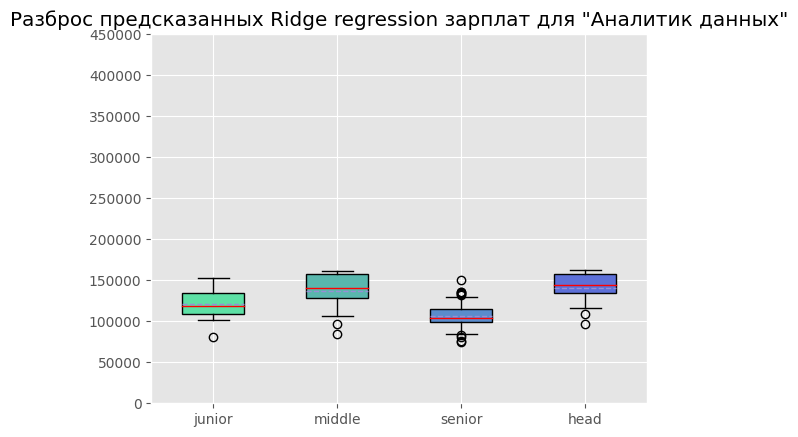

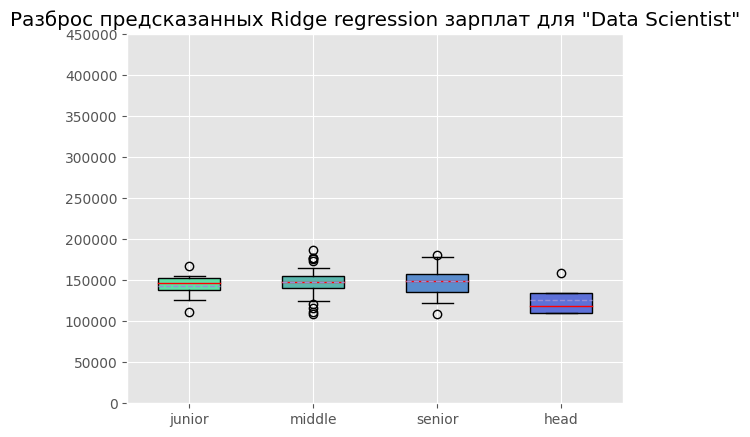

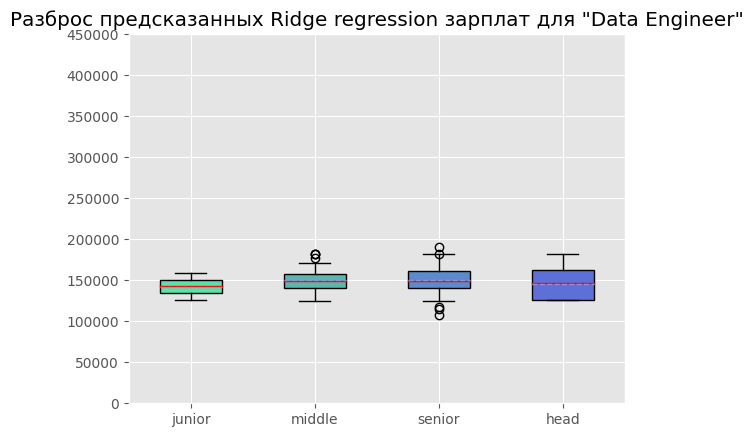

In [145]:
# Разброс предсказанных Ridge regression зарплат
for vac in lst_vacs:
    lst_grades_predict = []
    name = ' '.join(vac)
    filter_request = (df_predict['user_request'] == name)
    for index in range(len(grade_predictions)):
        data = df_predict[grade_predictions[index] & filter_request]['salary_ridge_predict']
        lst_grades_predict.append(data)
    fig, ax = plt.subplots()
    boxes = ax.boxplot(lst_grades_predict, labels=['junior','middle','senior','head'],
                    widths=0.5, patch_artist=True, whis=1,
                    boxprops=dict(color='black'),
                    capprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    showmeans=True, showfliers=True,
                    meanline=True, medianprops=dict(color='red'))

    for patch, color in zip(boxes['boxes'],colors):
        patch.set_facecolor(color)

    ax.set(ylim=(0, Full_vacs_df['salary_to'].max()))
    plt.title(f'Разброс предсказанных Ridge regression зарплат для "{name}"')
    plt.show()

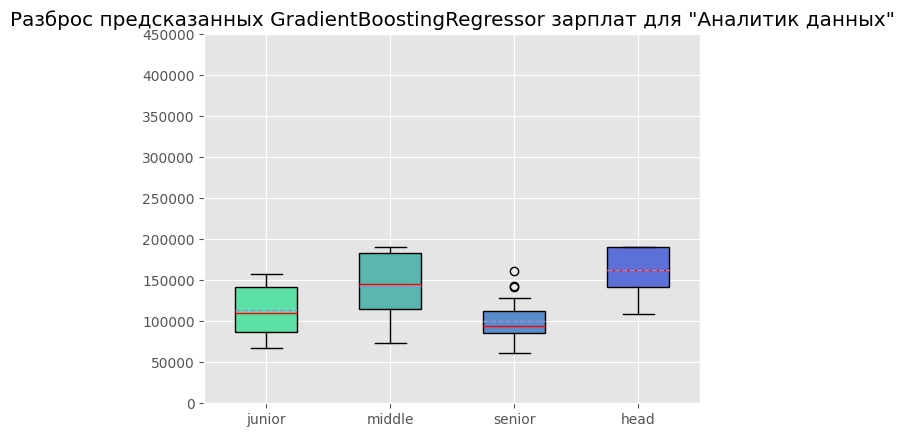

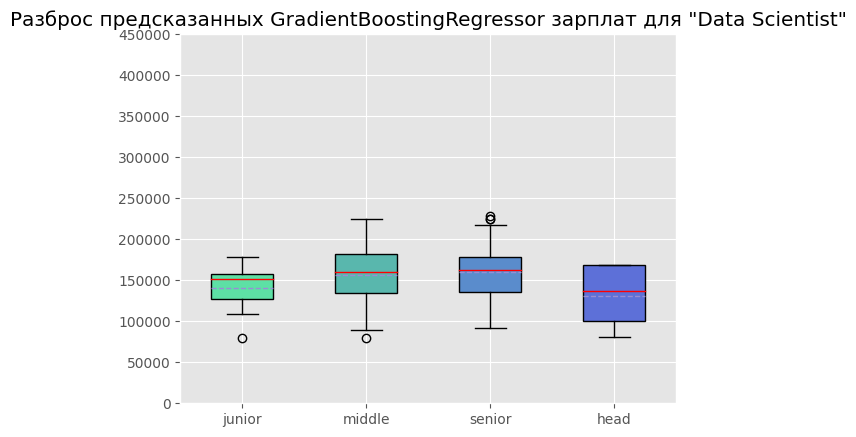

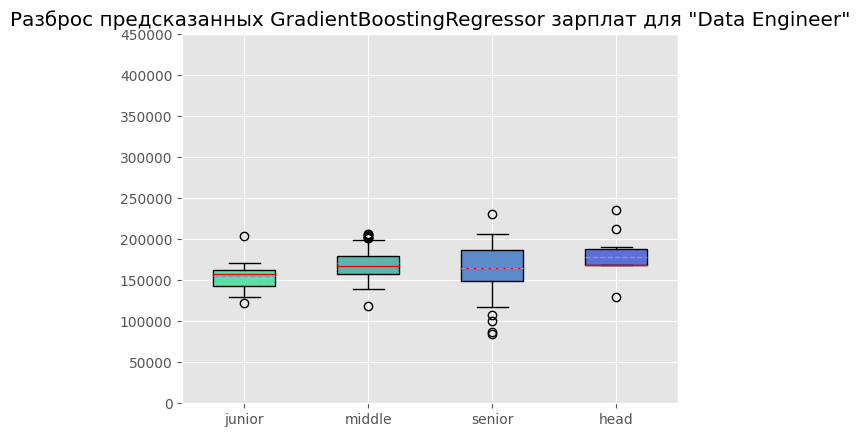

In [144]:
# Разброс предсказанных GradientBoostingRegressor зарплат
for vac in lst_vacs:
    lst_grades_predict = []
    name = ' '.join(vac)
    filter_request = (df_predict['user_request'] == name)
    for index in range(len(grade_predictions)):
        data = df_predict[grade_predictions[index] & filter_request]['salary_GBR_predict']
        lst_grades_predict.append(data)
    fig, ax = plt.subplots()
    boxes = ax.boxplot(lst_grades_predict, labels=['junior','middle','senior','head'],
                    widths=0.5, patch_artist=True, whis=1,
                    boxprops=dict(color='black'),
                    capprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    showmeans=True, showfliers=True,
                    meanline=True, medianprops=dict(color='red'))

    for patch, color in zip(boxes['boxes'],colors):
        patch.set_facecolor(color)

    ax.set(ylim=(0, Full_vacs_df['salary_to'].max()))
    plt.title(f'Разброс предсказанных GradientBoostingRegressor зарплат для "{name}"')
    plt.show()

### Вывод: Для данных моделей и методов векторизации текста, текста вакансий кажутся одинаковыми. Поэтому предсказания зарплат почти одинаковые на всех градациях опыта и являются усредненным значением всех известных зарплат. Применение данных инструментов предсказания значений требует более тонкой настройки.

# Глоссарий

In [3]:
# примененные инструкции, выражения

int() - применение целочисленнго типа данных 
len() - длина итерируемого объекта, строки или списка
list(), lst = [] - создание списка
set() - создание множества
dict() - создание словаря
{}.keys(), {}.values(), {}.items() - методы словарей: список ключей, список значение, список пар ключ-значение
def название_функции(аргументы): return - создание функции
lambda lst: lst[] - безымянная, однострочная функция
try except - попробовать исполнить код и указать что делать в случае возникновения ошибки
for i in []: - цикл присваивания каждого элемента в итерируемой последовательности к перемнной i 
input("введите текст") - запрос ввода у пользователя
print() - "печать", вывод на экран
'str-str'.split('-') - строковый метод разделяющий строку на элементы списка с указанным разделителем "-"
'str'.strip('-,+') - копия строки без указанных символов
'-'.join([]) - соездинение элементов списка в строку символом "-" 
[].count('a') - считает кол-во указанных элементов в строке или списке
.append(data) - добавление элемента в список
.extend([]) - добавление всех элементов списка в список
range(1,10,2) - диапазон от 1 до 9 с шагом 2
url = f'строка{переменная1}{переменная2}' - строка с возможностью указания значений переменных в тексте
requests.get(url) - метод get из библиотеки запросов для получения даннх по запросу 
min(), max() - поиск минмиального или максимального значения в итерируемых объектах
sum() - возвращает сумму элементов в итерируемой последовательности
1 == 2, 1>2, 1>=2 - проверка на равенство, возвращает True или False
list[4:20] - возвращат "срез" списка или строки от 4 элемента по 20
zip([],[]) - соединяет два списка, элемент к элементу по очереди, на длину короткого списка
map(int, []) - применение функции к каждому элементу итерируемой последоватекльности
[str(num) if num % 2 == 0 else int(num) for num in range(10) ] - списочное выражение: создает список вложив него каждое значение из диапазона и применяет к каждому значению разные функции в зависимости четности/нечетности значения

pandas as pd:
df = pd.DataFrame(columns=[]) - создание DataFrame
pd.Series() - создание серии, одномерной структуры данных
df['колонка'] - вывести на экран колонку из таблицы
df['колонка' > 5] - вывести на экран такие строки из таблицы, в которых значения в определенной колонке соответствуют условию (применение фильтра к таблице по значениям в одной колонке)
pd.concat([df1, df2], ignore_index=True) - добавить строки из df2 к df1
pd.merge(df1, df2, on='id') - добавить колонки из df2 к df1 соединяя строки по значениям в колонке id
df['колонка'] = 5 - присвоение значения к каждой строке в колонке
df['колонка'].tolist() - вывести колонку в виде списка
df['колонка'].min() .max() .mean() .median() - минимальное, максимальное, среднее значение в колонке
df['колонка'].is_unique - проверка на уникальность значений в колонке
pd.to_datetime(df['колонка'],  format="%Y-%m-%d") - преобразование значений в колонке в тип данных "дата-время" по шаблону "%Y-%m-%d"
df['колонка'].apply(функция) - применить функцию к каждому ячейке в колонке
df['колонка'].value_counts() - подсчет числа повторений разных значений в колонке
df['колонка'].loc[2:4,2:5] - срез таблицы по названиям индексов (со второго по четвертый индекс строк, со второго по пятый индекс колонок)
df['колонка'].iloc[2:4,2:5] - срез таблицы по фактической очередности строк и колонок
.drop_duplicates(subset=['колонка'], inplace=True) - удаление строк, если в указанной колонке есть повторение значения
.dropna() - удаление строк, если есть в строке пустые значения
.notna() .isna() - проверка на наличие значения или отсутствия значения в ячейках колонки
.drop(columns=['колонка1','колонка2'], inplace=True) - удалить колонки
.to_json('vacs_desription.json') - сохранение объекта в файл json методом pandas
pd.read_json('vacs_desription.json') - чтение файла json методом pandas
.copy() - глубокая копия таблицы (копирует значения, а не ссылки на значения)
.shape - возвратит кортеж с указанием кол-ва строк и колонок в таблице
.dtype  - информация о типе данных в ячейках
.dtypes - информация о типах данных в колонках
.astype({'id': 'int64'}) - применение к колонке id целочисленный тип данных
df.info() - информация о таблице и типах данных в таблице
.index - вывести список индексов таблицы, среза таблицы и тп
.values - вывести списки значений строк
.sample(2) .head(2) .tail(2) - показать две случайные строки в таблице; две верхние; две последние
str.contains('junior|начинающий', na=False, flags=re.IGNORECASE, regex=True) == True) - проверка содержит ли строка в ячейке определенные подстроки
.sort_values(ascending=False) - сортировка НЕ-по-возрастанию (возрастание=False) 
.groupby('колонка1')['колонка2'].median() - группировка таблицы по повторяющимся значениям в колонке1, а в колонке 2 из образовавшихся групп численных значений показывать медианы.

SyntaxError: unmatched ')' (393523765.py, line 63)